# Import Libraries

In [1]:
from ase.visualize import view
from ase.io import read
from ase.data import atomic_numbers, vdw_radii
from ase.build import surface
from ase.build import add_adsorbate
from ase import Atoms
import numpy as np
from typing import List, Tuple, Optional
from scipy.spatial import KDTree
from itertools import combinations
import nglview
from tqdm import tqdm
from scipy.spatial import cKDTree

c:\Users\dangh\AppData\Local\Programs\Python\Python313\Lib\site-packages\nglview\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Supporting Functions

In [2]:
def atomic_radii(structure_path):
    """
    Tr√≠ch xu·∫•t b√°n k√≠nh nguy√™n t·ª≠ t·ª´ structure file .
    
    Parameters:
    -----------
    structure_path : str
        ƒê∆∞·ªùng d·∫´n ƒë·∫øn file .
    
    Returns:
    --------
    radii_dict : dict
        T·ª´ ƒëi·ªÉn ch·ª©a t√™n nguy√™n t·ªë v√† b√°n k√≠nh van der Waals.
    """
    try:
        atoms = read(structure_path)
    except Exception as e:
        raise ValueError(f"Kh√¥ng th·ªÉ ƒë·ªçc file : {e}")
    
    elements = set(atoms.get_chemical_symbols())
    radii_dict = {}
    for element in elements:
        atomic_number = atomic_numbers[element]
        radius = vdw_radii[atomic_number] if vdw_radii[atomic_number] != 0 else 1.0
        radii_dict[element] = radius
        print(f"{element} radius: {radius}")
    
    return radii_dict

def molecule_surface_area(atoms, atom_radii, num_points=100000):
    """
    T√≠nh di·ªán t√≠ch b·ªÅ m·∫∑t c·ªßa ph√¢n t·ª≠ theo g√≥c nh√¨n t·ª´ tr√™n xu·ªëng (m·∫∑t ph·∫≥ng xy) b·∫±ng ph∆∞∆°ng ph√°p Monte Carlo.

    Parameters:
    - atoms: ASE Atoms object, ch·ª©a th√¥ng tin v·ªã tr√≠ v√† k√Ω hi·ªáu h√≥a h·ªçc c·ªßa c√°c nguy√™n t·ª≠
    - atom_radii: dict, ch·ª©a b√°n k√≠nh nguy√™n t·ª≠ (v√≠ d·ª•: {'Al': 1.43, 'C': 1.7, 'H': 1.0})
    - num_points: int, s·ªë ƒëi·ªÉm ng·∫´u nhi√™n cho ∆∞·ªõc l∆∞·ª£ng Monte Carlo

    Returns:
    - area_angstrom2: float, di·ªán t√≠ch b·ªÅ m·∫∑t ∆∞·ªõc l∆∞·ª£ng (√Ö¬≤)
    - area_nm2: float, di·ªán t√≠ch b·ªÅ m·∫∑t ∆∞·ªõc l∆∞·ª£ng (nm¬≤)
    """
    # L·∫•y t·ªça ƒë·ªô x, y (b·ªè qua z) t·ª´ ƒë·ªëi t∆∞·ª£ng Atoms
    coords_xy = np.array([atom.position[:2] for atom in atoms])  # Shape (n_atoms, 2)

    # L·∫•y b√°n k√≠nh d·ª±a tr√™n k√Ω hi·ªáu h√≥a h·ªçc
    radii = np.array([atom_radii[atom.symbol] for atom in atoms])  # Shape (n_atoms,)

    # T√¨m h·ªôp gi·ªõi h·∫°n (bounding box)
    min_x = np.min(coords_xy[:, 0] - radii)
    max_x = np.max(coords_xy[:, 0] + radii)
    min_y = np.min(coords_xy[:, 1] - radii)
    max_y = np.max(coords_xy[:, 1] + radii)

    # T√≠nh di·ªán t√≠ch h·ªôp gi·ªõi h·∫°n
    box_area = (max_x - min_x) * (max_y - min_y)

    # T·∫°o ƒëi·ªÉm ng·∫´u nhi√™n trong h·ªôp gi·ªõi h·∫°n
    points_x = np.random.uniform(min_x, max_x, num_points)
    points_y = np.random.uniform(min_y, max_y, num_points)
    points = np.vstack((points_x, points_y)).T  # Shape (num_points, 2)

    # Ki·ªÉm tra xem c√°c ƒëi·ªÉm c√≥ n·∫±m trong h√¨nh tr√≤n c·ªßa nguy√™n t·ª≠ n√†o kh√¥ng
    inside_count = 0
    for i in range(num_points):
        for j, center in enumerate(coords_xy):
            distance = np.sqrt(np.sum((points[i] - center) ** 2))
            if distance <= radii[j]:
                inside_count += 1
                break  # ƒêi·ªÉm n·∫±m trong √≠t nh·∫•t m·ªôt h√¨nh tr√≤n, kh√¥ng c·∫ßn ki·ªÉm tra ti·∫øp

    # T√≠nh di·ªán t√≠ch
    area_angstrom2 = (inside_count / num_points) * box_area
    area_nm2 = area_angstrom2 / 100  # Chuy·ªÉn t·ª´ √Ö¬≤ sang nm¬≤
    print(f"Di·ªán t√≠ch b·ªÅ m·∫∑t ph√¢n t·ª≠ (Top view): {area_angstrom2:.2f} √Ö¬≤, {area_nm2:.4f} nm¬≤")
    return area_angstrom2, area_nm2

# H√†m t√≠nh kho·∫£ng c√°ch vector h√≥a
def compute_distances_vectorized(coords1, coords2):
    # H√†m d√πng ƒë·ªÉ ki·ªÉm tra s·ª± ch·ªìng ch√©o c·ªßa c√°c ƒëi·ªÉm tr√™n b·ªÅ m·∫∑t - Steric Hindrance
    diff = coords1[:, np.newaxis] - coords2  # Shape (n1, n2, 3)
    distances = np.sqrt(np.sum(diff**2, axis=2))  # Shape (n1, n2)
    return distances

# H√†m xoay ph√¢n t·ª≠ ng·∫´u nhi√™n theo tr·ª•c Z
def rotate_molecule_z_axis(adsorbate):
    """
    Rotate an ASE Atoms object around the Z-axis passing through the main atom (index 0)
    by a random angle in [0, 360) degrees.
    
    Parameters:
    adsorbate : ASE Atoms
        The molecule to rotate, containing atomic positions.
    
    Returns:
    rotated_adsorbate : ASE Atoms
        A copy of the input molecule with all atoms rotated around the Z-axis through the main atom.
    """
    # Create a copy to avoid modifying the original
    rotated_adsorbate = adsorbate.copy()
    
    # Get the position of the main atom (index 0) as pivot
    pivot = rotated_adsorbate[0].position.copy()
    
    # Generate random angle in degrees
    theta = np.random.uniform(0, 360)
    
    # Convert angle to radians
    theta_rad = np.radians(theta)
    
    # Rotation matrix for Z-axis
    rotation_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0],
        [np.sin(theta_rad), np.cos(theta_rad), 0],
        [0, 0, 1]
    ])
    
    # Translate all atoms so that pivot is at origin
    rotated_adsorbate.positions -= pivot
    
    # Apply rotation
    rotated_adsorbate.positions = np.dot(rotated_adsorbate.positions, rotation_matrix.T)
    
    # Translate back to restore pivot position
    rotated_adsorbate.positions += pivot
    
    return rotated_adsorbate

# Precursor/Inhibitor Configuration

In [3]:
def atomic_positions(structure_path):
    """
    ƒê·ªçc file c·∫•u tr√∫c (.xyz, .cif, ...) v√† in k√Ω hi·ªáu c√πng t·ªça ƒë·ªô c√°c nguy√™n t·ª≠.
    """
    atoms = read(structure_path)
    radius = atomic_radii(structure_path)
    #view(atoms)
    print("Atomic symbols:", atoms.get_chemical_symbols())
    print("Atomic positions (√Ö):")
    print(atoms.positions)
    # In t·ª´ng nguy√™n t·ª≠
    for symbol, pos in zip(atoms.get_chemical_symbols(), atoms.positions):
        print(f"{symbol}: x={pos[0]:.4f}, y={pos[1]:.4f}, z={pos[2]:.4f}")
    return atoms, radius

def atomic_remove_indices(atoms, remove_indices=None):
    """
    X√≥a c√°c nguy√™n t·ª≠ theo ch·ªâ s·ªë index, r·ªìi in ra c·∫•u tr√∫c c√≤n l·∫°i.
    """

    if remove_indices:
        # T·∫°o danh s√°ch c√°c index c·∫ßn gi·ªØ l·∫°i
        keep_mask = [i not in remove_indices for i in range(len(atoms))]
        atoms = atoms[keep_mask]

    # Hi·ªÉn th·ªã v√† in th√¥ng tin
    #view(atoms)
    print(f"Sau khi lo·∫°i b·ªè nguy√™n t·ª≠ th·ª© {remove_indices}, c·∫•u tr√∫c ph√¢n t·ª≠ m·ªõi l√†:")
    for i, (s, p) in enumerate(zip(atoms.get_chemical_symbols(), atoms.positions)):
        print(f"{i}: {s} - x={p[0]:.8f}, y={p[1]:.8f}, z={p[2]:.8f}")

    return atoms


# H√†m random coords cho ph√¢n t·ª≠
def generate_random_position_and_rotation(slab, adsorption_sites, z_offset=2.0, angle_range=(1, 360)):
    """
    Generate a random position strictly within the 2D surface of the slab (including non-rectangular cells),
    and rotation matrices.

    Parameters:
    - slab: ASE Atoms object
    - z_offset: float, distance above the top surface
    - angle_range: tuple, rotation angle range in degrees

    Returns:
    - position: (1, 3) np.ndarray, absolute cartesian coordinates [x, y, z]
    - rotx, roty, rotz: rotation matrices
    """
    import numpy as np

    # Get cell vectors
    cell = slab.get_cell()  # shape (3, 3)
    a1, a2 = cell[0], cell[1]  # Only surface plane
    #adsorption_sites[0][2]
    z_ads_max = np.max(np.array(adsorption_sites)[:, 2])
    z_value = z_ads_max + z_offset

    # Random fractional coords in 2D unit cell
    r1 = np.random.rand()
    r2 = np.random.rand()

    # Compute cartesian xy from lattice vectors
    xy = r1 * a1 + r2 * a2
    position = np.array([[xy[0], xy[1], z_value]])

    # Rotation angles
    alpha = np.radians(np.random.uniform(*angle_range))
    beta  = np.radians(np.random.uniform(*angle_range))
    gamma = np.radians(np.random.uniform(*angle_range))

    # Rotation matrices
    rotx = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha), np.cos(alpha)]
    ])
    roty = np.array([
        [np.cos(beta), 0, np.sin(beta)],
        [0, 1, 0],
        [-np.sin(beta), 0, np.cos(beta)]
    ])
    rotz = np.array([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])

    return position, rotx, roty, rotz



def rotate_adsorbate_flexible(adsorbate, ads_site, v1_type='two_atoms', indices=None):
    """
    Quay ph√¢n t·ª≠ ti·ªÅn ch·∫•t ƒë·ªÉ cƒÉn ch·ªânh vector t·ª´ main atom v·ªõi ontop_site, linh ho·∫°t gi·ªØa hai nguy√™n t·ª≠ ho·∫∑c centroid/midpoint.
    
    Parameters:
    -----------
    adsorbate : ASE Atoms
        ƒê·ªëi t∆∞·ª£ng ph√¢n t·ª≠ ti·ªÅn ch·∫•t (t·ª´ atomic_remove_indices).
    ontop_site : list
        T·ªça ƒë·ªô (x, y, z) c·ªßa site h·∫•p ph·ª• tr√™n b·ªÅ m·∫∑t.
    v1_type : str, optional
        Lo·∫°i vector v1: 'two_atoms' (vector gi·ªØa 2 nguy√™n t·ª≠) ho·∫∑c 'centroid' (midpoint cho 2 nguy√™n t·ª≠, centroid cho 3+). M·∫∑c ƒë·ªãnh l√† 'two_atoms'.
    indices : list, optional
        Danh s√°ch index c·ªßa nguy√™n t·ª≠:
        - V·ªõi 'two_atoms': 2 index (th·ª© hai ph·∫£i kh√°c 0).
        - V·ªõi 'centroid': 2 ho·∫∑c nhi·ªÅu index (kh√°c 0) ƒë·ªÉ t√≠nh midpoint/centroid.
        N·∫øu None, m·∫∑c ƒë·ªãnh l√† [0, 1] cho 'two_atoms' ho·∫∑c [1, 2] cho 'centroid'.
    
    Returns:
    --------
    rotated_adsorbate : ASE Atoms
        ƒê·ªëi t∆∞·ª£ng ph√¢n t·ª≠ ƒë√£ xoay v·ªõi main atom t·∫°i v·ªã tr√≠ ban ƒë·∫ßu, c·∫ßn d·ªãch th·ªß c√¥ng ƒë·∫øn ontop_site.
    angle : float
        G√≥c quay (radian) ƒë∆∞·ª£c √°p d·ª•ng.
    axis : list
        Tr·ª•c quay (x, y, z) ƒë∆∞·ª£c s·ª≠ d·ª•ng.
    """
    from scipy.spatial.transform import Rotation as R
    import numpy as np
    
    # Sao ch√©p adsorbate ƒë·ªÉ x·ª≠ l√Ω
    rotated_adsorbate = adsorbate.copy()
    
    # Pivot l√† main atom (nguy√™n t·ª≠ ƒë·∫ßu ti√™n, index 0)
    pivot = rotated_adsorbate[0].position.copy()
    
    # X·ª≠ l√Ω indices m·∫∑c ƒë·ªãnh
    if indices is None:
        indices = [1] if v1_type == 'two_atoms' else [1, 2]
    if v1_type == 'two_atoms' and len(indices) != 2:
        indices = [1]  # M·∫∑c ƒë·ªãnh l·∫•y nguy√™n t·ª≠ th·ª© hai n·∫øu kh√¥ng ƒë·ªß 2 index
    
    # T√≠nh vector v1
    if v1_type == 'two_atoms':
        if len(indices) < 2:
            raise ValueError("C·∫ßn √≠t nh·∫•t 2 index cho v1_type 'two_atoms'.")
        v1_start = pivot
        v1_end = rotated_adsorbate.positions[indices[1]]
        v1 = v1_end - v1_start
    elif v1_type == 'centroid':
        if len(indices) < 2:
            raise ValueError("C·∫ßn √≠t nh·∫•t 2 index cho v1_type 'centroid'.")
        other_atoms_positions = [rotated_adsorbate.positions[i] for i in indices]
        if len(indices) == 2:
            # Trung ƒëi·ªÉm c·ªßa 2 nguy√™n t·ª≠
            midpoint = np.mean(other_atoms_positions, axis=0)
            v1 = midpoint - pivot
        else:
            # Centroid c·ªßa 3 ho·∫∑c nhi·ªÅu nguy√™n t·ª≠
            centroid = np.mean(other_atoms_positions, axis=0)
            v1 = centroid - pivot
    else:
        raise ValueError("v1_type ph·∫£i l√† 'two_atoms' ho·∫∑c 'centroid'.")
    
    # Vector m·ª•c ti√™u: t·ª´ main atom ƒë·∫øn ads_site
    v2 = ads_site - pivot
    
    # Chu·∫©n h√≥a vector
    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)
    
    # T√≠nh to√°n g√≥c quay
    cross = np.cross(v1, v2)
    dot = np.dot(v1, v2)
    if np.linalg.norm(cross) < 1e-8:  # Vector th·∫≥ng h√†ng ho·∫∑c ng∆∞·ª£c chi·ªÅu
        if dot < 0:
            axis = np.array([1, 0, 0]) if not np.allclose(v1, [1, 0, 0]) else np.array([0, 1, 0])
            angle = np.pi
        else:
            axis = np.array([0, 0, 1])  # Kh√¥ng c·∫ßn quay
            angle = 0.0
    else:
        axis = cross / np.linalg.norm(cross)
        angle = np.arccos(np.clip(dot, -1.0, 1.0))
    
    # T·∫°o ƒë·ªëi t∆∞·ª£ng Rotation
    rotation = R.from_rotvec(angle * axis)
    
    # √Åp d·ª•ng quay quanh pivot
    rotated_adsorbate.translate(-pivot)  # D·ªãch pivot v·ªÅ g·ªëc
    rotated_adsorbate.positions = rotation.apply(rotated_adsorbate.positions)
    rotated_adsorbate.translate(pivot)   # D·ªãch l·∫°i v·ªÅ v·ªã tr√≠ ban ƒë·∫ßu
    
    # D·ªãch main atom ƒë·∫øn ads_site (kh√¥ng th√™m v√†o slab)
    #offset = ads_site - rotated_adsorbate[0].position
    #rotated_adsorbate.translate(offset)
    view(rotated_adsorbate)
    print(f"\nApplied rotation - Angle: {np.degrees(angle):.1f}¬∞, Axis: [{axis[0]:.2f}, {axis[1]:.2f}, {axis[2]:.2f}]")
    print(f"v1_type: {v1_type}, Indices used: {indices}")

    
    return rotated_adsorbate, angle, axis


# Substrate Surface Configuration

In [4]:
def generate_slab_from_cif(cif_path, miller_indices=(1, 0, 0), layers=4, vacuum=10.0, size=(1, 1, 1), repeat=(4, 4, 1)):
    """
    T·∫°o m·ªôt b·ªÅ m·∫∑t slab t·ª´ file CIF v·ªõi ch·ªâ s·ªë Miller t√πy ch·ªânh, t√≠nh di·ªán t√≠ch b·ªÅ m·∫∑t v√† gi·ªõi h·∫°n.

    Parameters:
    -----------
    cif_path : str
        ƒê∆∞·ªùng d·∫´n ƒë·∫øn file CIF ch·ª©a c·∫•u tr√∫c tinh th·ªÉ.
    miller_indices : tuple, optional
        Ch·ªâ s·ªë Miller (h, k, l) ƒë·ªÉ x√°c ƒë·ªãnh m·∫∑t ph·∫≥ng b·ªÅ m·∫∑t. M·∫∑c ƒë·ªãnh l√† (1, 0, 0).
    layers : int, optional
        S·ªë l·ªõp nguy√™n t·ª≠ trong slab. M·∫∑c ƒë·ªãnh l√† 4.
    vacuum : float, optional
        Kho·∫£ng ch√¢n kh√¥ng (√Ö) d·ªçc theo tr·ª•c z. M·∫∑c ƒë·ªãnh l√† 10.0.
    size : tuple, optional
        K√≠ch th∆∞·ªõc ban ƒë·∫ßu c·ªßa c·∫•u tr√∫c (nx, ny, nz) tr∆∞·ªõc khi l·∫∑p l·∫°i. M·∫∑c ƒë·ªãnh l√† (1, 1, 1).
    repeat : tuple, optional
        S·ªë l·∫ßn l·∫∑p l·∫°i theo x, y, z ƒë·ªÉ m·ªü r·ªông slab. M·∫∑c ƒë·ªãnh l√† (4, 4, 1).

    Returns:
    --------
    result : tuple
        (slab, surface_area, x_min, x_max, y_min, y_max)
        - slab: ASE Atoms object, ƒë·ªëi t∆∞·ª£ng slab ƒë√£ ƒë∆∞·ª£c t·∫°o
        - surface_area: float, di·ªán t√≠ch b·ªÅ m·∫∑t (nm¬≤) t√≠nh t·ª´ h·ªôp gi·ªõi h·∫°n xy
        - x_min, x_max, y_min, y_max: float, gi·ªõi h·∫°n t·ªça ƒë·ªô trong m·∫∑t ph·∫≥ng xy (√Ö)
    """
    # ƒê·ªçc c·∫•u tr√∫c t·ª´ file CIF
    structure = read(cif_path)

    # T·∫°o b·ªÅ m·∫∑t d·ª±a tr√™n ch·ªâ s·ªë Miller
    slab = surface(structure, miller_indices, layers=layers, vacuum=vacuum)

    # L·∫∑p l·∫°i slab ƒë·ªÉ tƒÉng k√≠ch th∆∞·ªõc
    slab = slab.repeat(repeat)

    # B·∫≠t PBC cho c·∫£ ba h∆∞·ªõng
    slab.pbc = [True, True, True]

    # T√≠nh di·ªán t√≠ch b·ªÅ m·∫∑t ch√≠nh x√°c theo cell vectors (√Ö¬≤)
    a1 = slab.cell[0]  # Vector theo x
    a2 = slab.cell[1]  # Vector theo y
    surface_area_angstrom2 = np.linalg.norm(np.cross(a1, a2))
    surface_area_nm2 = surface_area_angstrom2 / 100  # 1 nm¬≤ = 100 √Ö¬≤

    # In th√¥ng tin slab
    print(f"Slab created with Miller indices {miller_indices} and {len(slab)} atoms:")
    print(f"Cell: {slab.cell}")
    print(f"Surface area: {surface_area_nm2:.4f} nm¬≤")
    '''
    print("Atomic positions with symbols:")
    for i, (symbol, pos) in enumerate(zip(slab.get_chemical_symbols(), slab.positions)):
        print(f"Atom {i}: {symbol} - x={pos[0]:.4f}, y={pos[1]:.4f}, z={pos[2]:.4f}")
    '''

    return slab, surface_area_nm2


def adsorption_sites(slab: Atoms, nx: int = 3, ny: int = 2, distance: Optional[float] = None, site_type: str = "ontop", atom1_idx: Optional[int] = None, atom2_idx: Optional[int] = None) -> Tuple[Atoms, np.ndarray, List[np.ndarray]]:
    """
    Determine adsorption sites on the top layer of a flat slab surface by selecting atoms with
    x-coordinates <= the nth smallest x-value and y-coordinates <= the nth smallest y-value,
    and calculate specific adsorption sites (ontop, bridge, hollow3, hollow4) based on distance.
    Visualize all top layer atoms with filtered atoms highlighted. selected_positions is used
    only to calculate distance if atom1_idx and atom2_idx are provided.

    Parameters:
    -----------
    slab : ASE Atoms
        The slab structure from generate_slab_from_cif.
    nx : int, optional
        Number of smallest x-coordinates to define the upper x-limit. Default is 3.
    ny : int, optional
        Number of smallest y-coordinates to define the upper y-limit. Default is 2.
    distance : float, optional
        Distance between neighboring atoms to determine adsorption sites. If None, calculated from atom1_idx and atom2_idx.
    site_type : str, optional
        Type of adsorption site to calculate ('ontop', 'bridge', 'hollow3', 'hollow4'). Default is 'ontop'.
    atom1_idx : int, optional
        Index of the first atom to calculate distance. Default is None.
    atom2_idx : int, optional
        Index of the second atom to calculate distance. Default is None.

    Returns:
    --------
    combined_atoms : ASE Atoms
        Combined Atoms object containing all top layer atoms (original colors) plus filtered atoms highlighted in red.
    selected_positions : np.ndarray
        Array of selected atom positions within the defined region (used only for distance calculation).
    adsorption_sites : List[np.ndarray]
        List of calculated adsorption site coordinates (x, y, z) based on top_layer_positions.
    """
    # Step 1: Identify atoms in the top layer (exact Z maximum)
    positions = slab.get_positions()
    z_coords = positions[:, 2]
    z_max = np.max(z_coords)
    top_layer_mask = z_coords == z_max
    top_layer_positions = positions[top_layer_mask]
    top_layer_symbols = np.array(slab.get_chemical_symbols())[top_layer_mask]
    
    if len(top_layer_positions) == 0:
        raise ValueError("No atoms found in the top layer of the slab.")
    
    # Print number of atoms in the top layer
    print(f"Number of atoms in top layer at Z={z_max:.4f} √Ö: {len(top_layer_positions)}")
    
    # Step 2: Select nx smallest x-coordinates and ny smallest y-coordinates
    nth_x = nx
    nth_y = ny
    sorted_values_x = np.sort(np.unique(np.round(top_layer_positions[:, 0], decimals=10)))  # Sort x values
    sorted_values_y = np.sort(np.unique(np.round(top_layer_positions[:, 1], decimals=10)))  # Sort y values
    x_target = sorted_values_x[nth_x - 1]
    y_target = sorted_values_y[nth_y - 1]
    print(f"Gi√° tr·ªã X th·ª© {nth_x} nh·ªè nh·∫•t: {x_target}")
    print(f"Gi√° tr·ªã Y th·ª© {nth_y} nh·ªè nh·∫•t: {y_target}")

    mask = ((top_layer_positions[:, 0] <= x_target) & (top_layer_positions[:, 1] <= y_target))

    selected_positions = top_layer_positions[mask]
    selected_symbols = top_layer_symbols[mask]

    print(f"C√°c nguy√™n t·ª≠ trong top layer v·ªõi x <= {x_target} v√† y <= {y_target}:")
    for pos, sym in zip(selected_positions, selected_symbols):
        print(f"{sym}: {pos}")
    
    # Step 3: Calculate distance if not provided
    if distance is not None:
        print(f"Using provided distance: {distance:.8f} √Ö")
    elif atom1_idx is not None and atom2_idx is not None and 0 <= atom1_idx < len(selected_positions) and 0 <= atom2_idx < len(selected_positions):
        pos1 = selected_positions[atom1_idx][:2]  # First atom's x, y
        pos2 = selected_positions[atom2_idx][:2]  # Second atom's x, y
        distance = np.linalg.norm(pos1 - pos2)
        print(f"Kho·∫£ng c√°ch XY gi·ªØa 2 nguy√™n t·ª≠ {pos1} v√† {pos2}: {distance:.8f} √Ö (calculated from indices {atom1_idx} and {atom2_idx})")
    else:
        print("Warning: Distance not provided and not enough valid atom indices to calculate. Using default distance of 0.0 √Ö.")
        distance = 0.0
    '''
    print(f"Number of filtered atoms: {len(selected_positions)}")
    print("Filtered positions:")
    for i, pos in enumerate(selected_positions):
        print(f"  Atom {i}: ({pos[0]:.8f}, {pos[1]:.8f}, {pos[2]:.8f}) - {selected_symbols[i]}")
    '''
    
    if len(selected_positions) == 0:
        print("No atoms found with the selected x and y coordinate constraints.")
        return Atoms(), selected_positions, []

    # Step 4: Calculate adsorption sites
    adsorption_sites_list = calculate_adsorption_sites(top_layer_positions, distance, site_type)
    
    print(f"Number of calculated {site_type} adsorption sites: {len(adsorption_sites_list)}")
    print("Adsorption site positions:")
    for i, site in enumerate(adsorption_sites_list):
        print(f"  Site {i}: ({site[0]:.8f}, {site[1]:.8f}, {site[2]:.8f})")

    
    # Step 5: Create Atoms objects for visualization
    # All top layer atoms (original symbols and colors)
    top_layer_atoms = Atoms(
        symbols=top_layer_symbols,
        positions=top_layer_positions,
        cell=slab.get_cell(),
        pbc=slab.get_pbc()
    )
    
    # Filtered atoms (highlighted with 'X' symbol for red color)
    filtered_highlight_atoms = Atoms(
        symbols=['X'] * len(selected_positions),
        positions=selected_positions,
        cell=slab.get_cell(),
        pbc=slab.get_pbc()
    )
    
    # Combine both for visualization
    combined_atoms = top_layer_atoms + filtered_highlight_atoms
    
    # Visualize the combined structure
    print("Visualizing top layer atoms (original colors) with filtered atoms highlighted using ASE view...")
    
    # Return combined atoms, selected positions, and calculated adsorption sites
    return combined_atoms, selected_positions, adsorption_sites_list

def calculate_adsorption_sites(top_layer_positions: np.ndarray, distance: float, site_type: str) -> List[np.ndarray]:
    """
    Calculate adsorption sites (ontop, bridge, hollow3, hollow4) based on top layer positions and distance.

    Parameters:
    -----------
    top_layer_positions : np.ndarray
        Array of all atom positions in the top layer (Z_max).
    distance : float
        Distance between neighboring atoms to determine adsorption sites.
    site_type : str
        Type of adsorption site to calculate ('ontop', 'bridge', 'hollow3', 'hollow4').
    z_max : float
        Z-coordinate of the top layer.

    Returns:
    --------
    adsorption_sites : List[np.ndarray]
        List of calculated adsorption site coordinates (x, y, z).
    """
    adsorption_sites_list = []
    tolerance = 1e-5  # Tolerance for distance comparison

    if site_type == "ontop":
        # For ontop, use all top layer positions directly
        adsorption_sites_list = [pos for pos in top_layer_positions]
    else:
        for i, pos1 in enumerate(top_layer_positions):
            for j, pos2 in enumerate(top_layer_positions):
                if i < j:  # Avoid self-comparison and duplicate pairs
                    dist = np.linalg.norm(pos1[:2] - pos2[:2])
                    if np.isclose(dist, distance, rtol=tolerance, atol=tolerance):
                        # Bridge: Midpoint between two atoms
                        if site_type == "bridge":
                            bridge_site = (pos1 + pos2) / 2
                            #bridge_site = np.append(bridge_site, z_max)  # Add z-coordinate
                            # Check for duplicates using np.allclose
                            is_duplicate = False
                            for existing_site in adsorption_sites_list:
                                if np.allclose(bridge_site, existing_site, rtol=tolerance, atol=tolerance):
                                    is_duplicate = True
                                    break
                            if not is_duplicate:
                                adsorption_sites_list.append(bridge_site)
                        
                        # Hollow3: Center of a triangle (requires 3 atoms)
                        elif site_type == "hollow3":
                            for k, pos3 in enumerate(top_layer_positions):
                                if k > j:
                                    dist2 = np.linalg.norm(pos2[:2] - pos3[:2])
                                    dist3 = np.linalg.norm(pos1[:2] - pos3[:2])
                                    if (np.isclose(dist2, distance, rtol=tolerance, atol=tolerance) and
                                        np.isclose(dist3, distance, rtol=tolerance, atol=tolerance)):
                                        hollow3_site = (pos1 + pos2 + pos3) / 3
                                        #hollow3_site = np.append(hollow3_site, z_max)
                                        # Check for duplicates using np.allclose
                                        is_duplicate = False
                                        for existing_site in adsorption_sites_list:
                                            if np.allclose(hollow3_site, existing_site, rtol=tolerance, atol=tolerance):
                                                is_duplicate = True
                                                break
                                        if not is_duplicate:
                                            adsorption_sites_list.append(hollow3_site)
                        
                        # Hollow4: Center of a square (requires 4 atoms)
                        elif site_type == "hollow4":
                            for k, pos3 in enumerate(top_layer_positions):
                                if k > j:
                                    dist2 = np.linalg.norm(pos2[:2] - pos3[:2])
                                    if np.isclose(dist2, distance, rtol=tolerance, atol=tolerance):
                                        for l, pos4 in enumerate(top_layer_positions):
                                            if l > k:
                                                dist3 = np.linalg.norm(pos3[:2] - pos4[:2])
                                                dist4 = np.linalg.norm(pos1[:2] - pos4[:2])
                                                if (np.isclose(dist3, distance, rtol=tolerance, atol=tolerance) and
                                                    np.isclose(dist4, distance, rtol=tolerance, atol=tolerance)):
                                                    # Check if atoms form a square (approximate)
                                                    if np.allclose(np.abs(dist - dist2), 0, atol=tolerance) and \
                                                       np.allclose(np.abs(dist - dist3), 0, atol=tolerance) and \
                                                       np.allclose(np.abs(dist - dist4), 0, atol=tolerance):
                                                        hollow4_site = (pos1 + pos2 + pos3 + pos4) / 4
                                                        #hollow4_site = np.append(hollow4_site, z_max)
                                                        # Check for duplicates using np.allclose
                                                        is_duplicate = False
                                                        for existing_site in adsorption_sites_list:
                                                            if np.allclose(hollow4_site, existing_site, rtol=tolerance, atol=tolerance):
                                                                is_duplicate = True
                                                                break
                                                        if not is_duplicate:
                                                            adsorption_sites_list.append(hollow4_site)

    return adsorption_sites_list




# Run Simulation

In [5]:
N = 3                      # S·ªë v√≤ng l·∫∑p m√¥ ph·ªèng / S·ªë cycle
N_gas = 10000              # S·ªë ph√¢n t·ª≠ trong m·ªói l·∫ßn m√¥ ph·ªèng (precursors or inhibitors)

# S·ªë ƒëi·ªÉm h·∫•p ph·ª• tr√™n b·ªÅ m·∫∑t g·∫ßn nh·∫•t v·ªõi precursors/ inhibitors ƒëang x√©t
MAX_SITES = 20

# Inhibitor v√† Precursor 
# Kh·ªüi t·∫°o m·∫£ng v·ªõi precursors
#number_gas_precursor = np.array([0])  # 1D, Shape (1,) L∆∞u l·∫°i s·ªë l∆∞·ª£ng ph√¢n t·ª≠ kh√≠ trong gas phase v·ªõi Precursors
#number_ads_precursor = np.array([0])  # 1D, Shape (1,) L∆∞u l·∫°i s·ªë l∆∞·ª£ng ph√¢n t·ª≠ kh√≠ ƒë√£ h·∫•p ph·ª• tr√™n b·ªÅ m·∫∑t v·ªõi Precursors
#Sn_ads_phase_t = np.array([[-10, -10, -10]])  # 2D, Shape (1, 3) L∆∞u gi√° tr·ªã nguy√™n t·ª≠ trong ti·ªÅn ch·∫•t TMA ·ªü pha h·∫•p ph·ª•
#Cl_ads_phase_t = np.array([[-10, -10, -10]])   # 2D, Shape (1, 3) L∆∞u gi√° tr·ªã nguy√™n t·ª≠ trong ti·ªÅn ch·∫•t TMA ·ªü pha h·∫•p ph·ª•

# Kh·ªüi t·∫°o m·∫£ng v·ªõi inhibitors
#number_gas_inhibitor = np.array([0])  # 1D, Shape (1,) L∆∞u l·∫°i s·ªë l∆∞·ª£ng ph√¢n t·ª≠ kh√≠ trong gas phase v·ªõi Inhibitors
#number_ads_inhibitor = np.array([0])  # 1D, Shape (1,) L∆∞u l·∫°i s·ªë l∆∞·ª£ng ph√¢n t·ª≠ kh√≠ ƒë√£ h·∫•p ph·ª• tr√™n b·ªÅ m·∫∑t v·ªõi Inhibitors
#S_ads_phase_t_ET = np.array([[-10, -10, -10]])  # Shape (1, 3) L∆∞u gi√° tr·ªã nguy√™n t·ª≠ S trong inhibitor ET ·ªü pha h·∫•p ph·ª•
#C_ads_phase_t_ET = np.array([[-10, -10, -10]])  # Shape (1, 3) L∆∞u gi√° tr·ªã nguy√™n t·ª≠ C trong inhibitor ET ·ªü pha h·∫•p ph·ª•
#H_ads_phase_t_ET = np.array([[-10, -10, -10]])  # Shape (1, 3) L∆∞u gi√° tr·ªã nguy√™n t·ª≠ H trong inhibitor ET ·ªü pha h·∫•p ph·ª•




In [6]:

slab, surface_area_nm2 = generate_slab_from_cif(r"C:\Users\dangh\Documents\TaiLieu\ThS Phenikaa\AS-ALD Simulation\CIF Files\SiO2_mp-8352_computed.cif",
                              miller_indices=(1, 1, 1), layers=4, vacuum=10.0, size=(1, 1, 1), repeat=(20, 20, 1))

view(slab, viewer='ngl')

Slab created with Miller indices (1, 1, 1) and 9600 atoms:
Cell: Cell([[105.51260719999999, 0.0, 0.0], [52.75630359999998, 91.37659825472883, 0.0], [0.0, 0.0, 35.6148112980221]])
Surface area: 96.4138 nm¬≤


In [7]:
#print(radius["Sn"])
#print(molecules.positions)
#print(molecules.positions[4,2])
atoms, radius = atomic_positions(r"C:\Users\dangh\Documents\TaiLieu\ThS Phenikaa\AS-ALD Simulation\sn_cl_structure.cif")
# X√≥a nguy√™n t·ª≠ ·ªü d√≤ng 1 v√† 3 (t√≠nh t·ª´ 0)
atoms_filtered = atomic_remove_indices(atoms, remove_indices=[1])
_, _, adsorption_sites = adsorption_sites(slab, nx=3, ny=2, site_type="hollow3", atom1_idx=0, atom2_idx=1)

# Build k-d tree
cu_tree = cKDTree(adsorption_sites)
# ƒê√°nh s·ªë th·ª© t·ª± cho c√°c ƒëi·ªÉm
order_sub = np.arange(1, len(adsorption_sites) + 1)  # M·∫£ng 1D t·ª´ 1 ƒë·∫øn s·ªë ƒëi·ªÉm h·∫•p ph·ª•

# Ch·ªçn site ƒë·∫ßu ti√™n ƒë·ªÉ th·ª≠ nghi·ªám
selected_site = adsorption_sites[0]
# Quay ph√¢n t·ª≠
rotated_adsorbate, angle, axis = rotate_adsorbate_flexible(atoms_filtered, selected_site, v1_type='centroid', indices=[1, 2, 3])
# T√≠nh di·ªán t√≠ch b·ªÅ m·∫∑t
molecule_area_angstrom2, molecule_area_nm2 = molecule_surface_area(rotated_adsorbate, atom_radii=radius)


#add_adsorbate(slab, rotated_adsorbate, height=2, position=(selected_site[0], selected_site[1]), offset=(0, 0))

Sn radius: 2.17
Cl radius: 1.75
Atomic symbols: ['Sn', 'Cl', 'Cl', 'Cl', 'Cl']
Atomic positions (√Ö):
[[3.16851134 1.83746502 2.3883634 ]
 [0.82791464 1.83786156 2.38816274]
 [3.94971036 4.04376269 2.38816274]
 [3.94811464 0.73466495 4.2998625 ]
 [3.94881217 0.73386231 0.4777625 ]]
Sn: x=3.1685, y=1.8375, z=2.3884
Cl: x=0.8279, y=1.8379, z=2.3882
Cl: x=3.9497, y=4.0438, z=2.3882
Cl: x=3.9481, y=0.7347, z=4.2999
Cl: x=3.9488, y=0.7339, z=0.4778
Sau khi lo·∫°i b·ªè nguy√™n t·ª≠ th·ª© [1], c·∫•u tr√∫c ph√¢n t·ª≠ m·ªõi l√†:
0: Sn - x=3.16851134, y=1.83746502, z=2.38836340
1: Cl - x=3.94971036, y=4.04376269, z=2.38816274
2: Cl - x=3.94811464, y=0.73466495, z=4.29986250
3: Cl - x=3.94881217, y=0.73386231, z=0.47776250
Number of atoms in top layer at Z=25.6148 √Ö: 400
Gi√° tr·ªã X th·ª© 3 nh·ªè nh·∫•t: 7.91344554
Gi√° tr·ªã Y th·ª© 2 nh·ªè nh·∫•t: 6.091773217
C√°c nguy√™n t·ª≠ trong top layer v·ªõi x <= 7.91344554 v√† y <= 6.091773217:
O: [ 2.63781518  1.5229433  25.6148113 ]
O: [ 5.27563036 

In [8]:
view(atoms)

<Popen: returncode: None args: ['c:\\Users\\dangh\\AppData\\Local\\Programs\...>

In [9]:
#print(radius["Sn"])
#print(molecules.positions)
#print(molecules.positions[4,2])
inhibitor_atoms, inhibitor_radius = atomic_positions(r"C:\Users\dangh\Documents\TaiLieu\ThS Phenikaa\AS-ALD Simulation\CIF Files\Conformer3D_COMPOUND_CID_6343.sdf")
# X√≥a nguy√™n t·ª≠ (t√≠nh t·ª´ 0)
atoms_filtered = atomic_remove_indices(inhibitor_atoms, remove_indices=[8])
# Quay ph√¢n t·ª≠
rotated_inhibitor, angle, axis = rotate_adsorbate_flexible(atoms_filtered, selected_site, v1_type='centroid', indices=[0,1])
#view(atoms_filtered)
inhibitor_area_angstrom2, inhibitor_area_nm2 = molecule_surface_area(rotated_inhibitor, atom_radii=inhibitor_radius)
# K·∫øt h·ª£p c√°c t·ª´ ƒëi·ªÉn radius
radius = radius.copy()  # B·∫Øt ƒë·∫ßu v·ªõi radius c·ªßa precursor
radius.update(inhibitor_radius)   # C·∫≠p nh·∫≠t v·ªõi radius c·ªßa inhibitor, gi·ªØ c√°c gi√° tr·ªã kh√¥ng tr√πng l·∫∑p

H radius: 1.2
C radius: 1.7
S radius: 1.8
Atomic symbols: ['S', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
Atomic positions (√Ö):
[[ 1.4415 -0.2624  0.    ]
 [-0.142   0.6214  0.    ]
 [-1.2995 -0.359   0.    ]
 [-0.1882  1.2622  0.8857]
 [-0.1882  1.2622 -0.8857]
 [-1.2851 -0.9984 -0.8892]
 [-1.2851 -0.9984  0.8893]
 [-2.2492  0.1861  0.    ]
 [ 2.2236  0.8269  0.    ]]
S: x=1.4415, y=-0.2624, z=0.0000
C: x=-0.1420, y=0.6214, z=0.0000
C: x=-1.2995, y=-0.3590, z=0.0000
H: x=-0.1882, y=1.2622, z=0.8857
H: x=-0.1882, y=1.2622, z=-0.8857
H: x=-1.2851, y=-0.9984, z=-0.8892
H: x=-1.2851, y=-0.9984, z=0.8893
H: x=-2.2492, y=0.1861, z=0.0000
H: x=2.2236, y=0.8269, z=0.0000
Sau khi lo·∫°i b·ªè nguy√™n t·ª≠ th·ª© [8], c·∫•u tr√∫c ph√¢n t·ª≠ m·ªõi l√†:
0: S - x=1.44150000, y=-0.26240000, z=0.00000000
1: C - x=-0.14200000, y=0.62140000, z=0.00000000
2: C - x=-1.29950000, y=-0.35900000, z=0.00000000
3: H - x=-0.18820000, y=1.26220000, z=0.88570000
4: H - x=-0.18820000, y=1.26220000, z=-0.88570000
5: 

# TEST 2

In [10]:
'''
ƒêo·∫°n code n√†y m√¥ ph·ªèng qu√° tr√¨nh h·∫•p ph·ª• c·ªßa inhibitors v√† precursors tr√™n b·ªÅ m·∫∑t slab k√®m ch·∫•t ƒë·ªìng ph·∫£n ·ª©ng H2O 
theo quy tr√¨nh ALD v·ªõi c√°c chu k·ª≥ ƒë∆∞·ª£c x√°c ƒë·ªãnh r√µ r√†ng.
n = s·ªë l·∫ßn l·∫∑p qu√° tr√¨nh trong 1 chu k·ª≥
N_gas = s·ªë ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p
'''
from ase import Atoms
from ase.visualize import view
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree

# ƒê·∫£m b·∫£o c√≥ b√°n k√≠nh cho O (t·ª´ ph·∫£n ·ª©ng H2O)
if 'O' not in radius:
    radius['O'] = 1.52  # B√°n k√≠nh van der Waals c·ªßa O, ƒë∆°n v·ªã √Ö (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh)

# Th√™m c√°c tham s·ªë m√¥ ph·ªèng (n·∫øu ch∆∞a c√≥)
n = 5  # S·ªë l·∫ßn l·∫∑p qu√° tr√¨nh trong 1 chu k·ª≥
N_gas = 7500  # S·ªë ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p
N = 20  # S·ªë chu k·ª≥ ALD
    
# Kh·ªüi t·∫°o danh s√°ch ƒë·ªÉ l∆∞u tr·ªØ c√°c ph√¢n t·ª≠
inhibitor_phase_molecules = []  # Ph√¢n t·ª≠ inhibitors trong giai ƒëo·∫°n kh√≠ (ch·ªâ chu k·ª≥ 1)
ads_inhibitor_molecules = []   # Ph√¢n t·ª≠ inhibitors ƒë√£ h·∫•p ph·ª• (ch·ªâ chu k·ª≥ 1)
ads_phase_molecules = []       # Ph√¢n t·ª≠ precursors ƒë√£ h·∫•p ph·ª• (t·∫•t c·∫£ chu k·ª≥)

# M·∫£ng theo d√µi s·ªë l∆∞·ª£ng ph√¢n t·ª≠
number_gas_inhibitors = np.array([])
number_ads_inhibitors = np.array([])
number_gas_precursor = np.array([])
number_ads_precursor = np.array([])

# ƒê·ªãnh nghƒ©a z-offset cho h·∫•p ph·ª• ontop (Sn tr√™n O)
z_offset = 2.0  # Kho·∫£ng c√°ch Sn-O, ƒë∆°n v·ªã √Ö (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh)

# Dictionary ƒë·ªÉ l∆∞u th√¥ng tin v·ªÅ chu k·ª≥ c·ªßa m·ªói v·ªã tr√≠ h·∫•p ph·ª• v√† ph√¢n t·ª≠
adsorption_cycle_info = {}  # key: (x, y, z) tuple c·ªßa v·ªã tr√≠ O, value: chu k·ª≥
molecules_by_cycle = {}     # key: chu k·ª≥, value: list c√°c ph√¢n t·ª≠

# Kh·ªüi t·∫°o cu_tree ban ƒë·∫ßu v·ªõi adsorption_sites
cu_tree = cKDTree(adsorption_sites)

# Kh·ªüi t·∫°o th√¥ng tin chu k·ª≥ cho c√°c v·ªã tr√≠ ban ƒë·∫ßu (chu k·ª≥ 0 - substrate)
for site in adsorption_sites:
    adsorption_cycle_info[tuple(site)] = 0

for cycle in range(1, N+1):
    print(f'\n{"="*50}')
    print(f'CYCLE {cycle}')
    print(f'{"="*50}')
    
    # Kh·ªüi t·∫°o molecules_by_cycle cho chu k·ª≥ hi·ªán t·∫°i
    molecules_by_cycle[cycle] = []
    
    if cycle == 1:
        # ========== 1. GIAI ƒêO·∫†N INHIBITORS (CH·ªà CHU K·ª≤ 1) ==========
        print(f'\n1. INHIBITORS PHASE')
        inhibitor_phase_molecules = []  # Reset danh s√°ch
        ads_inhibitor_molecules = []    # Reset danh s√°ch
        
        # Th·ª±c hi·ªán n l·∫ßn l·∫∑p inhibitors - M·ªñI ITERATION C√ì C·∫¢ GAS V√Ä ADSORPTION PHASE
        for iteration in range(1, n+1):
            print(f'   Iteration {iteration}/{n}')
            
            # 1a. Giai ƒëo·∫°n kh√≠ c·ªßa inhibitors (N_gas ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p)
            iteration_gas_molecules = []  # Ph√¢n t·ª≠ kh√≠ trong l·∫ßn l·∫∑p n√†y
            
            for i in tqdm(range(1, N_gas+1), desc="Generating gas layer", ncols=80):
                # Sao ch√©p ph√¢n t·ª≠ t·ª´ inhibitor_atoms
                molecule = inhibitor_atoms.copy()
                
                # T·∫°o v·ªã tr√≠ ng·∫´u nhi√™n v√† ma tr·∫≠n xoay
                pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
                
                # √Åp d·ª•ng xoay cho ph√¢n t·ª≠
                molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
                molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
                molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
                
                # D·ªãch ph√¢n t·ª≠ ƒë·∫øn v·ªã tr√≠ ng·∫´u nhi√™n
                offset = pos[0] - molecule[0].position
                molecule.translate(offset)
                
                # Ki·ªÉm tra steric hindrance CH·ªà v·ªõi molecules trong l·∫ßn l·∫∑p hi·ªán t·∫°i
                no_overlap = True
                if len(iteration_gas_molecules) > 0:
                    symbols = []
                    positions = []
                    
                    # Ch·ªâ th√™m t·ª´ l·∫ßn l·∫∑p hi·ªán t·∫°i
                    for prev_molecule in iteration_gas_molecules:
                        symbols.extend(prev_molecule.get_chemical_symbols())
                        positions.extend(prev_molecule.get_positions())
                    
                    all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                    
                    distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                    symbols1 = molecule.get_chemical_symbols()
                    symbols2 = all_gas_atoms.get_chemical_symbols()
                    radii1 = np.array([radius[s] for s in symbols1])
                    radii2 = np.array([radius[s] for s in symbols2])
                    radii_sums = radii1[:, None] + radii2[None, :]
                    
                    if not np.all(distances > radii_sums):
                        no_overlap = False
                
                if no_overlap:
                    iteration_gas_molecules.append(molecule.copy())
            print(f'   Generated {len(iteration_gas_molecules)} gas inhibitors in this iteration.')
            # Th√™m c√°c ph√¢n t·ª≠ kh√≠ c·ªßa l·∫ßn l·∫∑p n√†y v√†o t·ªïng
            inhibitor_phase_molecules.extend(iteration_gas_molecules)
            
            # 1b. ADSORPTION PHASE c·ªßa iteration n√†y - CH·ªà CHO C√ÅC PH√ÇN T·ª¨ TRONG ITERATION N√ÄY
            for molecule in tqdm(iteration_gas_molecules, desc=f"Iter {iteration} Inhibitors", ncols=80):
                molecule_copy = molecule.copy()
                
                # T√¨m v·ªã tr√≠ h·∫•p ph·ª• g·∫ßn nh·∫•t
                distances, indices = cu_tree.query(molecule_copy[0].position, k=min(MAX_SITES, len(adsorption_sites)))
                
                # ƒê·∫£m b·∫£o indices l√† m·∫£ng 1D
                if isinstance(indices, (int, np.integer)):
                    indices = [indices]
                
                adsorbed = False
                for k in indices:
                    if k >= len(adsorption_sites):
                        continue
                        
                    O_site = adsorption_sites[k]
                    ads_molecule = rotated_inhibitor.copy()
                    offset = O_site - ads_molecule[0].position
                    ads_molecule.translate(offset)
                    ads_molecule = rotate_molecule_z_axis(ads_molecule)
                    
                    # Ki·ªÉm tra steric hindrance v·ªõi T·∫§T C·∫¢ ads_inhibitor_molecules ƒë√£ h·∫•p ph·ª•
                    no_overlap = True
                    if len(ads_inhibitor_molecules) > 0:
                        symbols = []
                        positions = []
                        for prev_ads_molecule in ads_inhibitor_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                        symbols1 = ads_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                    
                    if no_overlap:
                        ads_inhibitor_molecules.append(ads_molecule.copy())
                        adsorbed = True
                        break
            print(f'   Iteration {iteration} complete: {len(ads_inhibitor_molecules)} adsorbed')
        
        print(f'   Total: {len(inhibitor_phase_molecules)} gas ‚Üí {len(ads_inhibitor_molecules)} adsorbed')
    
    # ========== 2. GIAI ƒêO·∫†N PRECURSORS (T·∫§T C·∫¢ CHU K·ª≤) ==========
    print(f'\n2. PRECURSORS PHASE')
    cycle_gas_molecules = []      # T·∫•t c·∫£ gas molecules trong chu k·ª≥ n√†y
    cycle_ads_molecules = []      # T·∫•t c·∫£ adsorbed molecules trong chu k·ª≥ n√†y
    
    # X√°c ƒë·ªãnh v·ªã tr√≠ h·∫•p ph·ª• cho chu k·ª≥ hi·ªán t·∫°i
    if cycle == 1:
        adsorption_positions = adsorption_sites
        adsorption_positions_cycle_map = {}
    else:
        # Chu k·ª≥ 2+: S·ª≠ d·ª•ng v·ªã tr√≠ O t·ª´ ads_phase_molecules
        adsorption_positions = []
        adsorption_positions_cycle_map = {}  # Map t·ª´ v·ªã tr√≠ ƒë·∫øn chu k·ª≥ g·ªëc
        
        for molecule in ads_phase_molecules:
            symbols = molecule.get_chemical_symbols()
            positions = molecule.get_positions()
            
            # T√¨m chu k·ª≥ c·ªßa ph√¢n t·ª≠ n√†y
            molecule_cycle = None
            for cycle_key, cycle_molecules in molecules_by_cycle.items():
                if molecule in cycle_molecules:
                    molecule_cycle = cycle_key
                    break
            
            if molecule_cycle is None:
                molecule_cycle = 1  # Default cho c√°c ph√¢n t·ª≠ t·ª´ chu k·ª≥ 1
            
            for idx, symbol in enumerate(symbols):
                if symbol == 'O':
                    pos_tuple = tuple(positions[idx])
                    adsorption_positions.append(positions[idx])
                    adsorption_positions_cycle_map[len(adsorption_positions)-1] = molecule_cycle
        
        adsorption_positions = np.array(adsorption_positions)
        
        if len(adsorption_positions) == 0:
            print('   No O atoms found for adsorption. Skipping precursor phase.')
            number_gas_inhibitors = np.append(number_gas_inhibitors, 0)
            number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
            number_gas_precursor = np.append(number_gas_precursor, 0)
            number_ads_precursor = np.append(number_ads_precursor, 0)
            continue
    
    # T·∫°o l·∫°i cu_tree v·ªõi adsorption_positions
    cu_tree = cKDTree(adsorption_positions)
    
    # Th·ª±c hi·ªán n l·∫ßn l·∫∑p precursors - M·ªñI ITERATION C√ì C·∫¢ GAS V√Ä ADSORPTION PHASE
    for iteration in range(1, n+1):
        print(f'   Iteration {iteration}/{n}')
        
        # 2a. Giai ƒëo·∫°n kh√≠ c·ªßa precursors (N_gas ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p)
        iteration_gas_molecules = []  # Ph√¢n t·ª≠ kh√≠ trong l·∫ßn l·∫∑p n√†y
        
        for i in tqdm(range(1, N_gas+1), desc="Generating gas layer", ncols=80):
            # Sao ch√©p ph√¢n t·ª≠ t·ª´ atoms
            molecule = atoms.copy()
            
            # T·∫°o v·ªã tr√≠ ng·∫´u nhi√™n v√† ma tr·∫≠n xoay
            pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
            
            # √Åp d·ª•ng xoay cho ph√¢n t·ª≠
            molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
            molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
            molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
            
            # D·ªãch ph√¢n t·ª≠ ƒë·∫øn v·ªã tr√≠ ng·∫´u nhi√™n
            offset = pos[0] - molecule[0].position
            molecule.translate(offset)
            
            # Ki·ªÉm tra steric hindrance CH·ªà v·ªõi molecules trong l·∫ßn l·∫∑p hi·ªán t·∫°i
            no_overlap = True
            if len(iteration_gas_molecules) > 0:
                symbols = []
                positions = []
                
                # Ch·ªâ th√™m t·ª´ l·∫ßn l·∫∑p hi·ªán t·∫°i
                for prev_molecule in iteration_gas_molecules:
                    symbols.extend(prev_molecule.get_chemical_symbols())
                    positions.extend(prev_molecule.get_positions())
                
                all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                symbols1 = molecule.get_chemical_symbols()
                symbols2 = all_gas_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if not np.all(distances > radii_sums):
                    no_overlap = False
            
            if no_overlap:
                iteration_gas_molecules.append(molecule.copy())
        print(f'   Generated {len(iteration_gas_molecules)} gas precursors in this iteration.')
        # Th√™m c√°c ph√¢n t·ª≠ kh√≠ c·ªßa l·∫ßn l·∫∑p n√†y v√†o chu k·ª≥
        cycle_gas_molecules.extend(iteration_gas_molecules)
        
        # 2b. ADSORPTION PHASE c·ªßa iteration n√†y - CH·ªà CHO C√ÅC PH√ÇN T·ª¨ TRONG ITERATION N√ÄY
        for molecule in tqdm(iteration_gas_molecules, desc=f"Iter {iteration} Precursors", ncols=80):
            molecule_copy = molecule.copy()
            
            # T√¨m v·ªã tr√≠ h·∫•p ph·ª• g·∫ßn nh·∫•t
            k = min(MAX_SITES, len(adsorption_positions))
            distances, indices = cu_tree.query(molecule_copy[0].position, k=k)
            
            # ƒê·∫£m b·∫£o indices l√† m·∫£ng 1D
            if isinstance(indices, (int, np.integer)):
                indices = [indices]
            
            adsorbed = False
            for k_idx in indices:
                if k_idx >= len(adsorption_positions):
                    continue
                    
                O_site = adsorption_positions[k_idx]
                ads_molecule = rotated_adsorbate.copy()
                offset = O_site - ads_molecule[0].position
                
                # X√°c ƒë·ªãnh chu k·ª≥ g·ªëc c·ªßa v·ªã tr√≠ h·∫•p ph·ª• v√† target_layer
                if cycle == 1:
                    original_cycle = 0  # Substrate
                    target_layer = 1   # Layer 1 (tr√™n substrate)
                    layer_z_offset = z_offset  # Layer 1 lu√¥n c√≥ z_offset c·ªë ƒë·ªãnh t·ª´ substrate
                else:
                    original_cycle = adsorption_positions_cycle_map[k_idx]
                    target_layer = original_cycle + 1  # Layer ti·∫øp theo
                    # Layer_z_offset ƒë∆∞·ª£c t√≠nh t·ª´ substrate (layer 0)
                    layer_z_offset = target_layer * z_offset
                
                # Th√™m z-offset d·ª±a tr√™n target_layer
                offset += np.array([0, 0, layer_z_offset])
                    
                ads_molecule.translate(offset)
                ads_molecule = rotate_molecule_z_axis(ads_molecule)
                
                # LOGIC CH√çNH X√ÅC: Ki·ªÉm tra steric hindrance v·ªõi c√°c ph√¢n t·ª≠ t·ª´ target_layer ƒë·∫øn cycle hi·ªán t·∫°i
                no_overlap = True
                blocking_layer = None
                
                # Ki·ªÉm tra steric hindrance v·ªõi t·∫•t c·∫£ c√°c layer t·ª´ target_layer ƒë·∫øn cycle hi·ªán t·∫°i
                for check_layer in range(target_layer, cycle + 1):
                    check_molecules = []
                    
                    if check_layer == cycle:
                        # Layer hi·ªán t·∫°i: ki·ªÉm tra v·ªõi c√°c ph√¢n t·ª≠ ƒë√£ h·∫•p ph·ª• trong chu k·ª≥ hi·ªán t·∫°i
                        check_molecules = cycle_ads_molecules.copy()
                    else:
                        # Layer c≈© h∆°n: ki·ªÉm tra v·ªõi c√°c ph√¢n t·ª≠ ·ªü layer ƒë√≥
                        if check_layer in molecules_by_cycle:
                            check_molecules = molecules_by_cycle[check_layer].copy()
                    
                    if len(check_molecules) > 0:
                        symbols = []
                        positions = []
                        for prev_ads_molecule in check_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                        symbols1 = ads_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                            blocking_layer = check_layer
                            break  # D·ª´ng ngay khi g·∫∑p steric hindrance
                
                if no_overlap:
                    cycle_ads_molecules.append(ads_molecule.copy())
                    adsorbed = True
                    break
        print(f'   Iteration {iteration} complete: {len(cycle_ads_molecules)} adsorbed')
    print(f'   Adsorbed: {len(cycle_ads_molecules)} precursors')
    
    # ========== 3. GIAI ƒêO·∫†N PH·∫¢N ·ª®NG H2O (1 L·∫¶N/CHU K·ª≤) ==========
    print(f'\n3. H2O REACTION PHASE')
    
    cl_replaced_total = 0
    for molecule in tqdm(cycle_ads_molecules, desc="Processing H2O Reaction", ncols=80):
        # Thay to√†n b·ªô Cl b·∫±ng O
        symbols = molecule.get_chemical_symbols()
        positions = molecule.get_positions()
        cl_count = 0
        
        for idx, symbol in enumerate(symbols):
            if symbol == 'Cl':
                symbols[idx] = 'O'
                cl_count += 1
                # C·∫≠p nh·∫≠t th√¥ng tin chu k·ª≥ cho v·ªã tr√≠ O m·ªõi
                adsorption_cycle_info[tuple(positions[idx])] = cycle
        
        molecule.set_chemical_symbols(symbols)
        cl_replaced_total += cl_count
    
    print(f'   Replaced: {cl_replaced_total} Cl ‚Üí O atoms')
    
    # L∆∞u c√°c ph√¢n t·ª≠ c·ªßa chu k·ª≥ hi·ªán t·∫°i v√†o molecules_by_cycle
    molecules_by_cycle[cycle] = cycle_ads_molecules.copy()
    
    # Th√™m c√°c ph√¢n t·ª≠ ƒë√£ ph·∫£n ·ª©ng v√†o ads_phase_molecules
    ads_phase_molecules.extend(cycle_ads_molecules)
    
    # ========== 4. C·∫¨P NH·∫¨T S·ªê LI·ªÜU TH·ªêNG K√ä ==========
    number_gas_inhibitors = np.append(number_gas_inhibitors, len(inhibitor_phase_molecules) if cycle == 1 else 0)
    number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
    number_gas_precursor = np.append(number_gas_precursor, len(cycle_gas_molecules))
    number_ads_precursor = np.append(number_ads_precursor, len(cycle_ads_molecules))
    
    # ========== 5. T·ªîNG K·∫æT CHU K·ª≤ ==========
    print(f'\n--- CYCLE {cycle} SUMMARY ---')
    if cycle == 1:
        print(f'Inhibitors adsorbed: {len(ads_inhibitor_molecules)}')
    print(f'Precursors adsorbed: {len(cycle_ads_molecules)}')
    print(f'Total molecules in system: {len(ads_inhibitor_molecules) + len(ads_phase_molecules)}')

# ========== T·ªîNG K·∫æT CU·ªêI C√ôNG ==========
print(f'\n{"="*60}')
print(f'SIMULATION COMPLETED - FINAL SUMMARY')
print(f'{"="*60}')

total_inhibitors = len(ads_inhibitor_molecules)
total_precursors = len(ads_phase_molecules)
total_molecules = total_inhibitors + total_precursors

print(f'Total Cycles: {N}')
print(f'Total Inhibitors Adsorbed: {total_inhibitors}')
print(f'Total Precursors Adsorbed: {total_precursors}')
print(f'Total Molecules in System: {total_molecules}')

print(f'\nPrecursors by Cycle:')
for cycle in range(1, N+1):
    cycle_count = int(number_ads_precursor[cycle-1])
    print(f'  Cycle {cycle}: {cycle_count} precursors')

print(f'\nMolecules by Layer:')
for layer, molecules in molecules_by_cycle.items():
    print(f'  Layer {layer}: {len(molecules)} precursors')

print(f'\n{"="*60}')


CYCLE 1

1. INHIBITORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:25<00:00, 292.75it/s]


   Generated 204 gas inhibitors in this iteration.


Iter 1 Inhibitors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 204/204 [00:01<00:00, 156.68it/s]


   Iteration 1 complete: 197 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:26<00:00, 287.06it/s]


   Generated 203 gas inhibitors in this iteration.


Iter 2 Inhibitors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 203/203 [00:11<00:00, 17.15it/s]


   Iteration 2 complete: 262 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:25<00:00, 294.89it/s]


   Generated 205 gas inhibitors in this iteration.


Iter 3 Inhibitors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 205/205 [00:15<00:00, 13.10it/s]


   Iteration 3 complete: 264 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:25<00:00, 298.33it/s]


   Generated 196 gas inhibitors in this iteration.


Iter 4 Inhibitors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 196/196 [00:15<00:00, 12.52it/s]


   Iteration 4 complete: 267 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:28<00:00, 264.38it/s]


   Generated 211 gas inhibitors in this iteration.


Iter 5 Inhibitors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 211/211 [00:16<00:00, 12.41it/s]


   Iteration 5 complete: 269 adsorbed
   Total: 1019 gas ‚Üí 269 adsorbed

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 476.44it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:01<00:00, 127.85it/s]


   Iteration 1 complete: 113 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 498.76it/s]


   Generated 159 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 159/159 [00:03<00:00, 42.11it/s]


   Iteration 2 complete: 117 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 512.62it/s]


   Generated 158 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 158/158 [00:03<00:00, 42.56it/s]


   Iteration 3 complete: 120 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 496.78it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 41.44it/s]


   Iteration 4 complete: 120 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 499.47it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 41.28it/s]


   Iteration 5 complete: 120 adsorbed
   Adsorbed: 120 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 120/120 [00:00<00:00, 43195.72it/s]


   Replaced: 360 Cl ‚Üí O atoms

--- CYCLE 1 SUMMARY ---
Inhibitors adsorbed: 269
Precursors adsorbed: 120
Total molecules in system: 389

CYCLE 2

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 504.14it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:01<00:00, 119.16it/s]


   Iteration 1 complete: 112 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 488.28it/s]


   Generated 168 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 44.03it/s]


   Iteration 2 complete: 115 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 494.84it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 43.93it/s]


   Iteration 3 complete: 115 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 492.08it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 43.66it/s]


   Iteration 4 complete: 115 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 497.40it/s]


   Generated 164 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 43.64it/s]


   Iteration 5 complete: 115 adsorbed
   Adsorbed: 115 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 115/115 [00:00<00:00, 60000.62it/s]


   Replaced: 345 Cl ‚Üí O atoms

--- CYCLE 2 SUMMARY ---
Precursors adsorbed: 115
Total molecules in system: 504

CYCLE 3

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 473.50it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:02<00:00, 72.43it/s]


   Iteration 1 complete: 105 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 482.69it/s]


   Generated 167 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 43.99it/s]


   Iteration 2 complete: 109 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 481.50it/s]


   Generated 162 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 44.16it/s]


   Iteration 3 complete: 110 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 513.87it/s]


   Generated 157 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 157/157 [00:03<00:00, 43.18it/s]


   Iteration 4 complete: 111 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 499.94it/s]


   Generated 163 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [00:03<00:00, 43.98it/s]


   Iteration 5 complete: 111 adsorbed
   Adsorbed: 111 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 111/111 [00:00<00:00, 65860.48it/s]


   Replaced: 333 Cl ‚Üí O atoms

--- CYCLE 3 SUMMARY ---
Precursors adsorbed: 111
Total molecules in system: 615

CYCLE 4

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 499.82it/s]


   Generated 167 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 44.64it/s]


   Iteration 1 complete: 9 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 498.42it/s]


   Generated 160 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 160/160 [00:03<00:00, 43.59it/s]


   Iteration 2 complete: 15 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 479.53it/s]


   Generated 169 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 169/169 [00:03<00:00, 44.46it/s]


   Iteration 3 complete: 18 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 507.40it/s]


   Generated 160 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 160/160 [00:03<00:00, 44.71it/s]


   Iteration 4 complete: 21 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 492.56it/s]


   Generated 169 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 169/169 [00:03<00:00, 43.17it/s]


   Iteration 5 complete: 22 adsorbed
   Adsorbed: 22 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 22/22 [00:00<00:00, 37693.91it/s]


   Replaced: 66 Cl ‚Üí O atoms

--- CYCLE 4 SUMMARY ---
Precursors adsorbed: 22
Total molecules in system: 637

CYCLE 5

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 505.52it/s]


   Generated 168 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 44.80it/s]


   Iteration 1 complete: 1 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 510.38it/s]


   Generated 165 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:03<00:00, 44.65it/s]


   Iteration 2 complete: 1 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 504.38it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 44.63it/s]


   Iteration 3 complete: 2 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 490.31it/s]


   Generated 167 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 43.43it/s]


   Iteration 4 complete: 3 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 491.06it/s]


   Generated 168 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 43.02it/s]


   Iteration 5 complete: 3 adsorbed
   Adsorbed: 3 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00, 6323.07it/s]


   Replaced: 9 Cl ‚Üí O atoms

--- CYCLE 5 SUMMARY ---
Precursors adsorbed: 3
Total molecules in system: 640

CYCLE 6

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 503.24it/s]


   Generated 157 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 157/157 [00:03<00:00, 44.28it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 494.56it/s]


   Generated 163 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [00:03<00:00, 43.49it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 503.45it/s]


   Generated 159 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 159/159 [00:03<00:00, 42.59it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 489.19it/s]


   Generated 164 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 42.27it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 492.93it/s]


   Generated 166 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 41.90it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 6 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 640

CYCLE 7

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 492.05it/s]


   Generated 169 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 169/169 [00:03<00:00, 43.50it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 486.09it/s]


   Generated 166 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 43.98it/s]


   Iteration 2 complete: 2 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 499.96it/s]


   Generated 163 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [00:03<00:00, 43.55it/s]


   Iteration 3 complete: 2 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 506.45it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 43.61it/s]


   Iteration 4 complete: 3 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 500.79it/s]


   Generated 168 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 43.97it/s]


   Iteration 5 complete: 3 adsorbed
   Adsorbed: 3 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00, 4206.92it/s]


   Replaced: 9 Cl ‚Üí O atoms

--- CYCLE 7 SUMMARY ---
Precursors adsorbed: 3
Total molecules in system: 643

CYCLE 8

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 507.50it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 43.59it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 503.21it/s]


   Generated 163 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [00:03<00:00, 42.74it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 487.34it/s]


   Generated 162 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 42.04it/s]


   Iteration 3 complete: 1 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 498.05it/s]


   Generated 166 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 43.15it/s]


   Iteration 4 complete: 1 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 486.81it/s]


   Generated 167 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 43.46it/s]


   Iteration 5 complete: 1 adsorbed
   Adsorbed: 1 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 4198.50it/s]


   Replaced: 3 Cl ‚Üí O atoms

--- CYCLE 8 SUMMARY ---
Precursors adsorbed: 1
Total molecules in system: 644

CYCLE 9

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 488.87it/s]


   Generated 174 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 174/174 [00:03<00:00, 44.25it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 509.25it/s]


   Generated 165 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:03<00:00, 44.83it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 514.87it/s]


   Generated 161 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 44.53it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 518.25it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 44.63it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 513.65it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 44.56it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 9 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 10

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 502.39it/s]


   Generated 169 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 169/169 [00:03<00:00, 44.67it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 506.29it/s]


   Generated 163 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [00:03<00:00, 43.93it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 509.21it/s]


   Generated 162 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 44.68it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 514.48it/s]


   Generated 165 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:03<00:00, 44.95it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 514.37it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 44.46it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 10 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 11

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 501.53it/s]


   Generated 164 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 43.69it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 526.69it/s]


   Generated 159 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 159/159 [00:03<00:00, 45.85it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 512.84it/s]


   Generated 166 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 45.38it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 530.39it/s]


   Generated 162 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 45.39it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 523.68it/s]


   Generated 161 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 45.25it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 11 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 12

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 522.62it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 45.47it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 519.20it/s]


   Generated 162 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 45.08it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 514.93it/s]


   Generated 165 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:03<00:00, 45.22it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 516.85it/s]


   Generated 167 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 45.36it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 524.98it/s]


   Generated 166 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 44.81it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 12 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 13

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:13<00:00, 536.20it/s]


   Generated 157 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 157/157 [00:03<00:00, 45.60it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 533.91it/s]


   Generated 157 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 157/157 [00:03<00:00, 45.24it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 524.60it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 44.99it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 514.68it/s]


   Generated 167 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 45.39it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 494.52it/s]


   Generated 158 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 158/158 [00:03<00:00, 41.23it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 13 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 14

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 495.17it/s]


   Generated 166 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 44.43it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 490.67it/s]


   Generated 166 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 44.60it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 479.65it/s]


   Generated 165 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:03<00:00, 44.28it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:15<00:00, 483.42it/s]


   Generated 166 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 43.22it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 520.98it/s]


   Generated 159 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 159/159 [00:03<00:00, 44.53it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 14 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 15

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 512.26it/s]


   Generated 159 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 159/159 [00:03<00:00, 45.40it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 520.67it/s]


   Generated 164 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 45.14it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 531.14it/s]


   Generated 158 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 158/158 [00:03<00:00, 45.55it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 515.60it/s]


   Generated 168 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 45.46it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 515.54it/s]


   Generated 164 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 45.32it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 15 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 16

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 535.32it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 45.52it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 529.45it/s]


   Generated 161 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 45.07it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 504.04it/s]


   Generated 169 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 169/169 [00:03<00:00, 45.06it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 523.84it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 45.53it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 515.68it/s]


   Generated 166 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 44.79it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 16 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 17

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 527.81it/s]


   Generated 164 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 45.33it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 529.27it/s]


   Generated 158 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 158/158 [00:03<00:00, 45.07it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 516.37it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 164/164 [00:03<00:00, 45.52it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 524.34it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 44.94it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 512.39it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 45.23it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 17 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 18

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 532.97it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 45.24it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 520.97it/s]


   Generated 166 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 45.92it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 507.28it/s]


   Generated 166 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 45.60it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 513.95it/s]


   Generated 168 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 45.52it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 504.46it/s]


   Generated 167 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 45.18it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 18 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 19

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 527.97it/s]


   Generated 163 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [00:03<00:00, 45.46it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 519.14it/s]


   Generated 167 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 167/167 [00:03<00:00, 45.11it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 516.72it/s]


   Generated 166 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [00:03<00:00, 45.21it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 517.87it/s]


   Generated 168 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:03<00:00, 45.50it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 517.06it/s]


   Generated 165 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:03<00:00, 45.13it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 19 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 20

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 531.43it/s]


   Generated 158 gas precursors in this iteration.


Iter 1 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 158/158 [00:03<00:00, 45.43it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 518.29it/s]


   Generated 161 gas precursors in this iteration.


Iter 2 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 45.69it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 531.45it/s]


   Generated 160 gas precursors in this iteration.


Iter 3 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 160/160 [00:03<00:00, 45.57it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 525.29it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161/161 [00:03<00:00, 45.60it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7500/7500 [00:14<00:00, 517.81it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [00:03<00:00, 44.83it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]

   Replaced: 0 Cl ‚Üí O atoms

--- CYCLE 20 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

SIMULATION COMPLETED - FINAL SUMMARY
Total Cycles: 20
Total Inhibitors Adsorbed: 269
Total Precursors Adsorbed: 375
Total Molecules in System: 644

Precursors by Cycle:
  Cycle 1: 120 precursors
  Cycle 2: 115 precursors
  Cycle 3: 111 precursors
  Cycle 4: 22 precursors
  Cycle 5: 3 precursors
  Cycle 6: 0 precursors
  Cycle 7: 3 precursors
  Cycle 8: 1 precursors
  Cycle 9: 0 precursors
  Cycle 10: 0 precursors
  Cycle 11: 0 precursors
  Cycle 12: 0 precursors
  Cycle 13: 0 precursors
  Cycle 14: 0 precursors
  Cycle 15: 0 precursors
  Cycle 16: 0 precursors
  Cycle 17: 0 precursors
  Cycle 18: 0 precursors
  Cycle 19: 0 precursors
  Cycle 20: 0 precursors

Molecules by Layer:
  Layer 1: 120 precursors
  Layer 2: 115 precursors
  Layer 3: 111 precursors
  Layer 4: 22 precursors
  Layer 5: 3 precursors
  Layer 6: 0 precursors
  Layer 7: 3 precursors
  Layer 8: 1 precursors
  

In [11]:
# ========== 5. HI·ªÇN TH·ªä K·∫æT QU·∫¢ CU·ªêI C√ôNG ==========
print(f'\n{"="*60}')
print('FINAL SIMULATION RESULTS')
print(f'{"="*60}')
print(f'Total cycles completed: {N}')
print(f'Iterations per cycle: {n}')
print(f'Molecules per iteration: {N_gas}')
print(f'Total inhibitors adsorbed: {len(ads_inhibitor_molecules)}')
print(f'Total precursors processed through all cycles: {len(ads_phase_molecules)}')

# G·ªôp t·∫•t c·∫£ ph√¢n t·ª≠ ƒë·ªÉ hi·ªÉn th·ªã b·∫±ng nglview
all_adsorbed_molecules = []
all_adsorbed_molecules.extend(ads_inhibitor_molecules)  # Inhibitors t·ª´ chu k·ª≥ 1
all_adsorbed_molecules.extend(ads_phase_molecules)      # Precursors t·ª´ t·∫•t c·∫£ chu k·ª≥

print(f'Total molecules for visualization: {len(all_adsorbed_molecules)}')

# T·∫°o structure t·ªïng h·ª£p ƒë·ªÉ hi·ªÉn th·ªã
if len(all_adsorbed_molecules) > 0:
    # G·ªôp t·∫•t c·∫£ symbols v√† positions
    all_symbols = []
    all_positions = []
    
    # Th√™m slab
    all_symbols.extend(slab.get_chemical_symbols())
    all_positions.extend(slab.get_positions())
    
    # Th√™m t·∫•t c·∫£ ph√¢n t·ª≠ ƒë√£ h·∫•p ph·ª•
    for molecule in all_adsorbed_molecules:
        all_symbols.extend(molecule.get_chemical_symbols())
        all_positions.extend(molecule.get_positions())
    
    # T·∫°o structure cu·ªëi c√πng
    final_structure = Atoms(symbols=all_symbols, positions=all_positions)
    print('‚úì Final structure created successfully for visualization')
    
    # HI·ªÇN TH·ªä K·∫æT QU·∫¢ B·∫∞NG NGLVIEW
    print('\nüìä VISUALIZATION')
    print('Displaying final structure with nglview...')
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('‚úì Structure displayed successfully')
    except Exception as e:
        print(f'‚úó Error displaying structure: {e}')
        print('You can manually visualize using: view(final_structure)')
    '''
        
else:
    print('‚ö†Ô∏è  No molecules were adsorbed. Only slab will be available for visualization.')
    final_structure = slab.copy()
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('‚úì Slab-only structure displayed')
    except Exception as e:
        print(f'‚úó Error displaying slab: {e}')
    '''

print('\nüéâ SIMULATION COMPLETED SUCCESSFULLY!')
print(f'Final structure variable: final_structure')
print(f'Total atoms in final structure: {len(final_structure)}')

# In th·ªëng k√™ chi ti·∫øt
print(f'\nüìà DETAILED STATISTICS:')
for i in range(len(number_gas_inhibitors)):
    cycle_num = i + 1
    print(f'Cycle {cycle_num}:')
    print(f'  - Gas inhibitors: {int(number_gas_inhibitors[i])}')
    print(f'  - Adsorbed inhibitors: {int(number_ads_inhibitors[i])}')
    print(f'  - Gas precursors: {int(number_gas_precursor[i])}')
    print(f'  - Adsorbed precursors: {int(number_ads_precursor[i])}')


view(final_structure, viewer='ngl')


FINAL SIMULATION RESULTS
Total cycles completed: 20
Iterations per cycle: 5
Molecules per iteration: 7500
Total inhibitors adsorbed: 269
Total precursors processed through all cycles: 375
Total molecules for visualization: 644
‚úì Final structure created successfully for visualization

üìä VISUALIZATION
Displaying final structure with nglview...

üéâ SIMULATION COMPLETED SUCCESSFULLY!
Final structure variable: final_structure
Total atoms in final structure: 13252

üìà DETAILED STATISTICS:
Cycle 1:
  - Gas inhibitors: 1019
  - Adsorbed inhibitors: 269
  - Gas precursors: 802
  - Adsorbed precursors: 120
Cycle 2:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas precursors: 819
  - Adsorbed precursors: 115
Cycle 3:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas precursors: 811
  - Adsorbed precursors: 111
Cycle 4:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas precursors: 825
  - Adsorbed precursors: 22
Cycle 5:
  - Gas inhibitors: 0
  - Adsorbed inhibitors

# Analyze Results and Drawing Plots

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class ALDAnalyzer:
    """
    Class ƒë·ªÉ ph√¢n t√≠ch k·∫øt qu·∫£ m√¥ ph·ªèng ALD v√† t√≠nh to√°n c√°c th√¥ng s·ªë theo c√¥ng th·ª©c.
    """
    
    def __init__(self, surface_area_nm2, inhibitor_size_top_view_nm2, precursor_size_top_view_nm2,
                 total_adsorption_sites, z_offset=2.0, substrate_size_nm2=None, 
                 density=2.96, molecular_mass=101.96, avogadro=6.022e23):
        """
        Kh·ªüi t·∫°o analyzer v·ªõi c√°c th√¥ng s·ªë c∆° b·∫£n.
        
        Parameters:
        -----------
        surface_area_nm2 : float
            Di·ªán t√≠ch b·ªÅ m·∫∑t substrate (nm¬≤)
        inhibitor_size_top_view_nm2 : float  
            K√≠ch th∆∞·ªõc ph√¢n t·ª≠ inhibitor nh√¨n t·ª´ tr√™n (nm¬≤)
        precursor_size_top_view_nm2 : float  
            K√≠ch th∆∞·ªõc ph√¢n t·ª≠ precursor nh√¨n t·ª´ tr√™n (nm¬≤)
        total_adsorption_sites : int
            T·ªïng s·ªë v·ªã tr√≠ h·∫•p ph·ª• c√≥ th·ªÉ
        z_offset : float
            Kho·∫£ng c√°ch z gi·ªØa c√°c layer (√Ö)
        substrate_size_nm2 : float, optional
            K√≠ch th∆∞·ªõc substrate, m·∫∑c ƒë·ªãnh b·∫±ng surface_area_nm2
        density : float
            M·∫≠t ƒë·ªô c·ªßa Al2O3 ALD film (g/cm¬≥), m·∫∑c ƒë·ªãnh 2.96
        molecular_mass : float
            Kh·ªëi l∆∞·ª£ng ph√¢n t·ª≠ c·ªßa Al2O3 (g/mol), m·∫∑c ƒë·ªãnh 101.96
        avogadro : float
            S·ªë Avogadro (mol‚Åª¬π), m·∫∑c ƒë·ªãnh 6.022e23
        """
        self.surface_area_nm2 = surface_area_nm2
        self.inhibitor_size_top_view_nm2 = inhibitor_size_top_view_nm2
        self.precursor_size_top_view_nm2 = precursor_size_top_view_nm2
        self.total_adsorption_sites = total_adsorption_sites
        self.z_offset = z_offset
        self.substrate_size_nm2 = substrate_size_nm2 or surface_area_nm2
        
        # C√°c h·∫±ng s·ªë cho t√≠nh to√°n thickness theo c√¥ng th·ª©c 21, 22
        self.density = density  # g/cm¬≥
        self.molecular_mass = molecular_mass  # g/mol
        self.avogadro = avogadro  # mol‚Åª¬π
        
        # T√≠nh monolayer thickness theo c√¥ng th·ª©c 21
        self.monolayer_thickness_angstrom = ((molecular_mass / (density * avogadro))**(1/3)) * 1e8  # √Ö
        
        # Storage for simulation results
        self.simulation_data = {}
        
    def add_simulation_data(self, cycle, inhibitors_gas, inhibitors_ads, 
                          precursors_gas, precursors_ads, exposure_time=1.0):
        """
        Th√™m d·ªØ li·ªáu m√¥ ph·ªèng cho m·ªôt chu k·ª≥.
        """
        self.simulation_data[cycle] = {
            'inhibitors_gas': inhibitors_gas,
            'inhibitors_ads': inhibitors_ads,
            'precursors_gas': precursors_gas,
            'precursors_ads': precursors_ads,
            'exposure_time': exposure_time
        }
    
    def calculate_areal_coverage_precursor(self, num_adsorbed_molecules):
        """
        T√≠nh to√°n areal coverage cho precursor theo c√¥ng th·ª©c (15).
        Areal Coverage (%) = (s·ªë ph√¢n t·ª≠ √ó di·ªán t√≠ch ph√¢n t·ª≠) / di·ªán t√≠ch substrate √ó 100
        
        L∆∞u √Ω: K·∫øt qu·∫£ c√≥ th·ªÉ > 100% n·∫øu ph√¢n t·ª≠ ch·ªìng l·∫•p ho·∫∑c k√≠ch th∆∞·ªõc ph√¢n t·ª≠ l·ªõn
        """
        coverage = (num_adsorbed_molecules * self.precursor_size_top_view_nm2) / self.substrate_size_nm2 * 100
        return coverage
    
    def calculate_areal_coverage_inhibitor(self, num_adsorbed_molecules):
        """
        T√≠nh to√°n areal coverage cho inhibitor.
        Areal Coverage (%) = (s·ªë ph√¢n t·ª≠ √ó di·ªán t√≠ch ph√¢n t·ª≠) / di·ªán t√≠ch substrate √ó 100
        
        L∆∞u √Ω: K·∫øt qu·∫£ c√≥ th·ªÉ > 100% n·∫øu ph√¢n t·ª≠ ch·ªìng l·∫•p ho·∫∑c k√≠ch th∆∞·ªõc phan t·ª≠ l·ªõn
        """
        coverage = (num_adsorbed_molecules * self.inhibitor_size_top_view_nm2) / self.substrate_size_nm2 * 100
        return coverage
    
    def calculate_point_coverage(self, num_adsorbed_molecules):
        """T√≠nh to√°n point coverage theo c√¥ng th·ª©c (16)."""
        coverage = (num_adsorbed_molecules / self.total_adsorption_sites) * 100
        return coverage
    
    def calculate_physical_impingement_per_unit_area(self, num_physical_impingement):
        """T√≠nh to√°n physical impingement per unit area theo c√¥ng th·ª©c (17)."""
        return num_physical_impingement / self.substrate_size_nm2
    
    def calculate_gpc_and_thickness(self, coverage_per_cycle_percent):
        """
        T√≠nh to√°n GPC v√† thickness d·ª±a tr√™n c√¥ng th·ª©c (21) v√† (22).
        
        C√¥ng th·ª©c (21): h = (M/(œÅ√óNA))^(1/3) - monolayer thickness
        C√¥ng th·ª©c (22): coverage (%/cycle) = (GPC/h) √ó 100
        => GPC = coverage (%/cycle) √ó h / 100
        
        Parameters:
        -----------
        coverage_per_cycle_percent : float
            % coverage th·ª±c t·∫ø cho m·ªói chu k·ª≥ (t·ª´ point coverage ho·∫∑c surface coverage)
            
        Returns:
        --------
        dict : {
            'gpc_angstrom': float,        # GPC in √Ö
            'gpc_nm': float,              # GPC in nm
            'monolayer_thickness': float  # h in √Ö
        }
        """
        # GPC t√≠nh t·ª´ c√¥ng th·ª©c (22): GPC = coverage (%) √ó h / 100
        gpc_angstrom = (coverage_per_cycle_percent / 100.0) * self.monolayer_thickness_angstrom
        gpc_nm = gpc_angstrom / 10.0  # 1 nm = 10 √Ö
        
        return {
            'gpc_angstrom': gpc_angstrom,
            'gpc_nm': gpc_nm,
            'monolayer_thickness': self.monolayer_thickness_angstrom
        }
    
    def calculate_selectivity(self, growth_area_coverage):
        """
        T√≠nh to√°n selectivity theo c√¥ng th·ª©c (20).
        
        Selectivity = (Growth_area - NonGrowth_area) / (Growth_area + NonGrowth_area) √ó 100
        
        Trong m√¥ ph·ªèng ALD:
        - Growth_area = v√πng c√≥ precursor h·∫•p ph·ª• (growth_area_coverage)
        - NonGrowth_area = v√πng c√≤n l·∫°i = 100% - Growth_area (bao g·ªìm inhibitor + free surface)
        
        Parameters:
        -----------
        growth_area_coverage : float
            % di·ªán t√≠ch ƒë∆∞·ª£c precursor bao ph·ªß (Growth area)
            
        Returns:
        --------
        float : selectivity (%)
            > 0: tƒÉng tr∆∞·ªüng ch·ªçn l·ªçc t·ªët (Growth > NonGrowth)
            < 0: tƒÉng tr∆∞·ªüng ch·ªçn l·ªçc k√©m (Growth < NonGrowth)
            = 0: c√¢n b·∫±ng (Growth = NonGrowth = 50%)
        """
        growth_area = growth_area_coverage
        nongrowth_area = 100.0 - growth_area_coverage
        
        total_area = growth_area + nongrowth_area  # Lu√¥n = 100%
        if total_area == 0:
            return 0.0
        
        selectivity = (growth_area - nongrowth_area) / total_area * 100
        return selectivity
    
    def get_cycle1_coverage_data(self):
        """L·∫•y d·ªØ li·ªáu coverage chi ti·∫øt cho cycle 1."""
        if 1 not in self.simulation_data:
            return {
                'inhibitor_coverage': 0, 
                'precursor_coverage': 0, 
                'free_surface': 100,
                'total_coverage': 0,
                'overlap_indicator': 0
            }
        
        data = self.simulation_data[1]
        inhibitor_coverage = self.calculate_areal_coverage_inhibitor(data['inhibitors_ads'])
        precursor_coverage = self.calculate_areal_coverage_precursor(data['precursors_ads'])
        
        # T·ªïng coverage - c√≥ th·ªÉ > 100% n·∫øu overlap
        total_coverage = inhibitor_coverage + precursor_coverage
        free_surface = 100.0 - total_coverage
        
        # Overlap indicator: n·∫øu total > 100%, c√≥ overlap
        overlap_indicator = total_coverage - 100.0 if total_coverage > 100.0 else 0
        
        return {
            'inhibitor_coverage': inhibitor_coverage,
            'precursor_coverage': precursor_coverage,
            'free_surface': free_surface,
            'total_coverage': total_coverage,
            'overlap_indicator': overlap_indicator,
            'inhibitor_molecules': data['inhibitors_ads'],
            'precursor_molecules': data['precursors_ads']
        }
    
    def calculate_growth_nongrowth_coverage(self):
        """
        T√≠nh to√°n growth_area_coverage v√† nongrowth_area_coverage d·ª±a tr√™n d·ªØ li·ªáu th·ª±c.
        
        Logic:
        - Total substrate area = 100%
        - Inhibitor area = di·ªán t√≠ch b·ªã inhibitor chi·∫øm (ch·ªâ cycle 1)
        - Precursor area = di·ªán t√≠ch b·ªã precursor chi·∫øm
        - Free area = di·ªán t√≠ch c√≤n l·∫°i t·ª± do
        
        For selectivity calculation:
        - Growth area = Precursor area (v√πng tƒÉng tr∆∞·ªüng th√†nh c√¥ng)
        - NonGrowth area = Free area (v√πng kh√¥ng tƒÉng tr∆∞·ªüng)
        
        Returns:
        --------
        tuple : (growth_coverage_data, nongrowth_coverage_data)
        """
        cycles = sorted(self.simulation_data.keys())
        growth_coverage_data = []
        nongrowth_coverage_data = []
        
        for cycle in cycles:
            data = self.simulation_data[cycle]
            
            # Precursor coverage (growth area)
            precursor_coverage = self.calculate_areal_coverage_precursor(data['precursors_ads'])
            free_surface = 100.0 - precursor_coverage
            
            growth_coverage_data.append(precursor_coverage)
            nongrowth_coverage_data.append(free_surface)
        
        return growth_coverage_data, nongrowth_coverage_data
    
    def analyze_precursor_cycles(self):
        """Ph√¢n t√≠ch c√°c chu k·ª≥ cho precursor v·ªõi c√°c c√¥ng th·ª©c ch√≠nh x√°c."""
        cycles = sorted(self.simulation_data.keys())
        
        results = {
            'cycles': cycles,
            'surface_coverage': [],
            'point_coverage': [],
            'cumulative_surface_coverage': [],
            'cumulative_point_coverage': [],
            'physical_impingement': [],
            'total_adsorbed': [],
            'thickness': [],
            'gpc': [],
            'coverage_per_cycle': [],
            'selectivity': []  # Th√™m selectivity v√†o results
        }
        
        cumulative_precursors = 0
        
        for cycle in cycles:
            data = self.simulation_data[cycle]
            precursors_ads = data['precursors_ads']
            precursors_gas = data['precursors_gas']
            cumulative_precursors += precursors_ads
            
            # Point coverage - d·ª±a tr√™n s·ªë l∆∞·ª£ng sites, lu√¥n ‚â§ 100%
            per_cycle_point_coverage = self.calculate_point_coverage(precursors_ads)
            cumulative_point_coverage = self.calculate_point_coverage(cumulative_precursors)
            
            # Surface coverage d·ª±a tr√™n point coverage (thay v√¨ areal coverage)
            per_cycle_surface_coverage = per_cycle_point_coverage
            cumulative_surface_coverage = cumulative_point_coverage
            
            # T√≠nh selectivity d·ª±a tr√™n cumulative point coverage
            selectivity = self.calculate_selectivity(cumulative_point_coverage)
            
            results['surface_coverage'].append(per_cycle_surface_coverage)
            results['cumulative_surface_coverage'].append(cumulative_surface_coverage)
            results['point_coverage'].append(per_cycle_point_coverage)
            results['cumulative_point_coverage'].append(cumulative_point_coverage)
            results['selectivity'].append(selectivity)  # L∆∞u selectivity
            
            # Physical impingement
            physical_impingement = self.calculate_physical_impingement_per_unit_area(precursors_gas)
            results['physical_impingement'].append(physical_impingement)
            
            # GPC calculation - s·ª≠ d·ª•ng point coverage (ch√≠nh x√°c h∆°n cho ALD)
            gpc_data = self.calculate_gpc_and_thickness(cumulative_point_coverage)
            
            # Thickness = cycle √ó GPC
            thickness_angstrom = cycle * gpc_data['gpc_angstrom']
            thickness_nm = thickness_angstrom / 10.0
            
            # L∆∞u k·∫øt qu·∫£
            results['total_adsorbed'].append(cumulative_precursors)
            results['thickness'].append(thickness_nm)
            results['gpc'].append(gpc_data['gpc_angstrom'])
            results['coverage_per_cycle'].append(cumulative_point_coverage)
        
        return results
    
    def plot_cycle1_coverage_bar(self, figsize=(12, 5)):
        """ƒê·ªì th·ªã c·ªôt: % bao ph·ªß c·ªßa inhibitor v√† precursor ·ªü cycle 1 (kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã)."""
        coverage_data = self.get_cycle1_coverage_data()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle('Cycle 1 Surface Coverage Analysis', fontsize=16, fontweight='bold')
        
        # Bi·ªÉu ƒë·ªì c·ªôt coverage theo %
        categories = ['Inhibitor', 'Precursor', 'Free Surface']
        coverages = [coverage_data['inhibitor_coverage'], 
                    coverage_data['precursor_coverage'],
                    coverage_data['free_surface']]
        colors = ['#FF6B6B', '#4DABF7', '#51CF66']
        
        bars1 = ax1.bar(categories, coverages, color=colors, alpha=0.8, edgecolor='black')
        ax1.set_title('Surface Area Coverage (%)', fontweight='bold')
        ax1.set_ylabel('Coverage (%)')
        ax1.set_ylim(0, 100)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Bi·ªÉu ƒë·ªì s·ªë l∆∞·ª£ng ph√¢n t·ª≠
        molecules = [coverage_data['inhibitor_molecules'], coverage_data['precursor_molecules']]
        molecule_categories = ['Inhibitor', 'Precursor']
        
        bars2 = ax2.bar(molecule_categories, molecules, color=colors[:2], alpha=0.8, edgecolor='black')
        ax2.set_title('Number of Adsorbed Molecules', fontweight='bold')
        ax2.set_ylabel('Number of Molecules')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        return fig, (ax1, ax2)
    
    def plot_surface_coverage_vs_cycle(self, results=None, figsize=(10, 6)):
        """ƒê·ªì th·ªã t∆∞∆°ng quan gi·ªØa surface coverage - cycle c·ªßa precursor (ch·ªâ cumulative, kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        cycles = results['cycles']
        
        # Ch·ªâ v·∫Ω cumulative
        ax.plot(cycles, results['cumulative_surface_coverage'], 's-', 
               label='Cumulative', linewidth=3, markersize=10, color='#1971C2')
        
        ax.set_title('Precursor Surface Coverage vs Cycle', fontsize=14, fontweight='bold')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Surface Coverage (%)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig, ax
    
    def plot_point_coverage_vs_cycle(self, results=None, figsize=(10, 6)):
        """ƒê·ªì th·ªã t∆∞∆°ng quan gi·ªØa point coverage - cycle c·ªßa precursor (ch·ªâ cumulative, kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        cycles = results['cycles']
        
        # Ch·ªâ v·∫Ω cumulative
        ax.plot(cycles, results['cumulative_point_coverage'], 's-', 
               label='Cumulative', linewidth=3, markersize=10, color='#2F9E44')
        
        ax.set_title('Precursor Point Coverage vs Cycle', fontsize=14, fontweight='bold')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Point Coverage (%)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig, ax
    
    def plot_coverage_vs_impingement(self, results=None, figsize=(10, 6)):
        """ƒê·ªì th·ªã t∆∞∆°ng quan gi·ªØa point coverage - physical impingement c·ªßa precursor (kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Ch·ªâ d·ªØ li·ªáu cho precursor
        precursor_point_coverage = results['point_coverage']
        precursor_impingement = results['physical_impingement']
        
        # V·∫Ω ƒë·ªì th·ªã scatter
        ax.scatter(precursor_impingement, precursor_point_coverage, 
                  s=100, alpha=0.8, color='#4DABF7', label='Precursor', edgecolors='black')
        
        # V·∫Ω ƒë∆∞·ªùng trend cho precursor n·∫øu c√≥ nhi·ªÅu ƒëi·ªÉm
        if len(precursor_impingement) > 1:
            z = np.polyfit(precursor_impingement, precursor_point_coverage, 1)
            p = np.poly1d(z)
            ax.plot(precursor_impingement, p(precursor_impingement), "--", alpha=0.8, color='#1971C2')
        
        ax.set_title('Point Coverage vs Physical Impingement', fontsize=14, fontweight='bold')
        ax.set_xlabel('Physical Impingement (#/nm¬≤)', fontsize=12)
        ax.set_ylabel('Point Coverage (%)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig, ax
    
    def plot_thickness_vs_cycle(self, results=None, figsize=(10, 6)):
        """ƒê·ªì th·ªã thickness vs cycle (kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        cycles = results['cycles']
        thickness = results['thickness']
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # V·∫Ω thickness
        ax.plot(cycles, thickness, 'o-', color='#1f77b4', linewidth=3, markersize=10, label='Thickness')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Thickness (nm)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        ax.set_title('Film Thickness vs Cycle', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        
        plt.tight_layout()
        return fig, ax

    def plot_selectivity_vs_cycle(self, results=None, figsize=(10, 6)):
        """
        ƒê·ªì th·ªã selectivity vs cycle (kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã).
        
        Selectivity ƒë∆∞·ª£c t√≠nh theo c√¥ng th·ª©c (20):
        Selectivity = (Growth_area - NonGrowth_area) / (Growth_area + NonGrowth_area) √ó 100
        
        Parameters:
        -----------
        results : dict, optional
            K·∫øt qu·∫£ t·ª´ analyze_precursor_cycles(). N·∫øu None s·∫Ω t√≠nh to√°n l·∫°i.
        figsize : tuple
            K√≠ch th∆∞·ªõc figure (width, height)
            
        Returns:
        --------
        tuple : (fig, ax)
            Figure v√† axes object c·ªßa matplotlib
        """
        if results is None:
            results = self.analyze_precursor_cycles()
        
        cycles = results['cycles']
        selectivity = results['selectivity']
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # V·∫Ω selectivity v·ªõi m√†u s·∫Øc ph√π h·ª£p
        # S·ª≠ d·ª•ng m√†u xanh l√° cho selectivity d∆∞∆°ng (t·ªët), m√†u ƒë·ªè cho √¢m (k√©m)
        colors = ['#2F9E44' if s >= 0 else '#E03131' for s in selectivity]
        
        # V·∫Ω ƒë∆∞·ªùng v√† ƒëi·ªÉm
        ax.plot(cycles, selectivity, '-', color='#495057', linewidth=2, alpha=0.7)
        ax.scatter(cycles, selectivity, c=colors, s=100, alpha=0.8, edgecolors='black', linewidth=1)
        
        # Th√™m ƒë∆∞·ªùng tham chi·∫øu t·∫°i y=0
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        ax.set_title('ALD Selectivity vs Cycle', fontsize=14, fontweight='bold')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Selectivity (%)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Th√™m legend gi·∫£i th√≠ch
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2F9E44', alpha=0.8, label='Positive (Good selectivity)'),
            Patch(facecolor='#E03131', alpha=0.8, label='Negative (Poor selectivity)')
        ]
        ax.legend(handles=legend_elements, loc='best', fontsize=10)
        
        # Thi·∫øt l·∫≠p gi·ªõi h·∫°n y ƒë·ªÉ hi·ªÉn th·ªã t·ªët h∆°n
        y_margin = max(abs(min(selectivity)), abs(max(selectivity))) * 0.1
        ax.set_ylim(min(selectivity) - y_margin, max(selectivity) + y_margin)
        
        plt.tight_layout()
        return fig, ax
    
    def generate_comprehensive_report(self, precursor_results=None):
        """T·∫°o b√°o c√°o t·ªïng h·ª£p chi ti·∫øt v·ªõi t√≠nh to√°n t·ª± ƒë·ªông."""
        if precursor_results is None:
            precursor_results = self.analyze_precursor_cycles()
        
        # T√≠nh to√°n t·ª± ƒë·ªông growth v√† nongrowth coverage
        growth_coverage_data, nongrowth_coverage_data = self.calculate_growth_nongrowth_coverage()
        
        cycle1_data = self.get_cycle1_coverage_data()
        
        report = []
        report.append("="*70)
        report.append("ALD SIMULATION COMPREHENSIVE ANALYSIS REPORT")
        report.append("="*70)
        report.append(f"Surface area: {self.surface_area_nm2:.4f} nm¬≤")
        report.append(f"Inhibitor size (top view): {self.inhibitor_size_top_view_nm2:.6f} nm¬≤")
        report.append(f"Precursor size (top view): {self.precursor_size_top_view_nm2:.6f} nm¬≤")
        report.append(f"Total adsorption sites: {self.total_adsorption_sites}")
        report.append(f"Z-offset between layers: {self.z_offset:.1f} √Ö")
        report.append(f"Al2O3 density: {self.density:.2f} g/cm¬≥")
        report.append(f"Al2O3 molecular mass: {self.molecular_mass:.2f} g/mol")
        report.append(f"Monolayer thickness (h): {self.monolayer_thickness_angstrom:.2f} √Ö")
        report.append("")
        
        # Cycle 1 Coverage Analysis
        report.append("CYCLE 1 SURFACE COVERAGE:")
        report.append("-" * 30)
        report.append(f"  Inhibitor coverage: {cycle1_data['inhibitor_coverage']:.2f}% ({cycle1_data['inhibitor_molecules']} molecules)")
        report.append(f"  Precursor coverage: {cycle1_data['precursor_coverage']:.2f}% ({cycle1_data['precursor_molecules']} molecules)")
        report.append(f"  Free surface: {cycle1_data['free_surface']:.2f}%")
        report.append("")
        
        # Precursor Analysis by Cycle
        report.append("PRECURSOR ANALYSIS BY CYCLE:")
        report.append("-" * 40)
        for i, cycle in enumerate(precursor_results['cycles']):
            report.append(f"CYCLE {cycle}:")
            report.append(f"  Surface coverage (cumulative): {precursor_results['cumulative_surface_coverage'][i]:.2f}%")
            report.append(f"  Point coverage (cumulative): {precursor_results['cumulative_point_coverage'][i]:.2f}%")
            report.append(f"  Physical impingement: {precursor_results['physical_impingement'][i]:.2f} #/nm¬≤")
            report.append(f"  GPC: {precursor_results['gpc'][i]:.3f} √Ö")
            report.append(f"  Coverage per cycle: {precursor_results['coverage_per_cycle'][i]:.2f}%")
            report.append(f"  Film thickness: {precursor_results['thickness'][i]:.3f} nm")
            report.append(f"  Total adsorbed precursors: {precursor_results['total_adsorbed'][i]}")
            report.append("")
        
        return "\n".join(report)


def create_analyzer_from_simulation_data(surface_area_nm2, inhibitor_size_top_view_nm2, 
                                       precursor_size_top_view_nm2, total_adsorption_sites,
                                       number_gas_inhibitors, number_ads_inhibitors, 
                                       number_gas_precursor, number_ads_precursor, z_offset=2.0,
                                       density=2.96, molecular_mass=101.96):
    """
    T·∫°o ALDAnalyzer t·ª´ d·ªØ li·ªáu m√¥ ph·ªèng c√≥ s·∫µn.
    """
    analyzer = ALDAnalyzer(surface_area_nm2, inhibitor_size_top_view_nm2, 
                          precursor_size_top_view_nm2, total_adsorption_sites, z_offset,
                          density=density, molecular_mass=molecular_mass)
    
    # Th√™m d·ªØ li·ªáu cho t·ª´ng chu k·ª≥
    n_cycles = len(number_gas_precursor)
    
    for cycle in range(1, n_cycles + 1):
        analyzer.add_simulation_data(
            cycle=cycle,
            inhibitors_gas=int(number_gas_inhibitors[cycle-1]),
            inhibitors_ads=int(number_ads_inhibitors[cycle-1]),
            precursors_gas=int(number_gas_precursor[cycle-1]),
            precursors_ads=int(number_ads_precursor[cycle-1])
        )
    
    return analyzer


def plot_all_ald_analysis(analyzer):
    """
    V·∫Ω t·∫•t c·∫£ c√°c ƒë·ªì th·ªã ph√¢n t√≠ch ALD theo y√™u c·∫ßu ƒë√£ c·∫≠p nh·∫≠t (kh√¥ng hi·ªÉn th·ªã gi√° tr·ªã tr√™n c√°c ƒëi·ªÉm).
    
    Parameters:
    -----------
    analyzer : ALDAnalyzer
        ƒê·ªëi t∆∞·ª£ng analyzer ƒë√£ ƒë∆∞·ª£c setup v·ªõi d·ªØ li·ªáu
    """
    # Ph√¢n t√≠ch d·ªØ li·ªáu precursor
    precursor_results = analyzer.analyze_precursor_cycles()
    
    # 1. ƒê·ªì th·ªã c·ªôt coverage cycle 1
    fig1, axes1 = analyzer.plot_cycle1_coverage_bar()
    
    # 2. Surface coverage vs cycle (ch·ªâ cumulative)
    fig2, ax2 = analyzer.plot_surface_coverage_vs_cycle(precursor_results)
    
    # 3. Point coverage vs cycle (ch·ªâ cumulative)
    fig3, ax3 = analyzer.plot_point_coverage_vs_cycle(precursor_results)
    
    # 4. Thickness vs cycle
    fig4, ax4 = analyzer.plot_thickness_vs_cycle(precursor_results)

    # 5. Selectivity vs cycle
    fig5, ax5 = analyzer.plot_selectivity_vs_cycle(precursor_results)
    
    return {
        'coverage_bar': (fig1, axes1),
        'surface_coverage': (fig2, ax2),
        'point_coverage': (fig3, ax3),
        'thickness': (fig4, ax4),
        'selectivity': (fig5, ax5)
    }


# V√≠ d·ª• s·ª≠ d·ª•ng:
"""
# T·∫°o analyzer t·ª´ d·ªØ li·ªáu m√¥ ph·ªèng
analyzer = create_analyzer_from_simulation_data(
    surface_area_nm2=your_surface_area,
    inhibitor_size_top_view_nm2=your_inhibitor_size,
    precursor_size_top_view_nm2=your_precursor_size,
    total_adsorption_sites=your_total_sites,
    number_gas_inhibitors=number_gas_inhibitors,
    number_ads_inhibitors=number_ads_inhibitors,
    number_gas_precursor=number_gas_precursor,
    number_ads_precursor=number_ads_precursor,
    z_offset=2.0,
    density=2.96,  # Al2O3 density
    molecular_mass=101.96  # Al2O3 molecular mass
)

# V·∫Ω t·∫•t c·∫£ ƒë·ªì th·ªã
plots = plot_all_ald_analysis(analyzer)

# In b√°o c√°o chi ti·∫øt
report = analyzer.generate_comprehensive_report()
print(report)

# Hi·ªÉn th·ªã c√°c ƒë·ªì th·ªã
import matplotlib.pyplot as plt
plt.show()
"""

'\n# T·∫°o analyzer t·ª´ d·ªØ li·ªáu m√¥ ph·ªèng\nanalyzer = create_analyzer_from_simulation_data(\n    surface_area_nm2=your_surface_area,\n    inhibitor_size_top_view_nm2=your_inhibitor_size,\n    precursor_size_top_view_nm2=your_precursor_size,\n    total_adsorption_sites=your_total_sites,\n    number_gas_inhibitors=number_gas_inhibitors,\n    number_ads_inhibitors=number_ads_inhibitors,\n    number_gas_precursor=number_gas_precursor,\n    number_ads_precursor=number_ads_precursor,\n    z_offset=2.0,\n    density=2.96,  # Al2O3 density\n    molecular_mass=101.96  # Al2O3 molecular mass\n)\n\n# V·∫Ω t·∫•t c·∫£ ƒë·ªì th·ªã\nplots = plot_all_ald_analysis(analyzer)\n\n# In b√°o c√°o chi ti·∫øt\nreport = analyzer.generate_comprehensive_report()\nprint(report)\n\n# Hi·ªÉn th·ªã c√°c ƒë·ªì th·ªã\nimport matplotlib.pyplot as plt\nplt.show()\n'

ALD SIMULATION COMPREHENSIVE ANALYSIS REPORT
Surface area: 96.4138 nm¬≤
Inhibitor size (top view): 0.180265 nm¬≤
Precursor size (top view): 0.319546 nm¬≤
Total adsorption sites: 722
Z-offset between layers: 2.0 √Ö
Al2O3 density: 6.95 g/cm¬≥
Al2O3 molecular mass: 150.71 g/mol
Monolayer thickness (h): 3.30 √Ö

CYCLE 1 SURFACE COVERAGE:
------------------------------
  Inhibitor coverage: 50.30% (269 molecules)
  Precursor coverage: 39.77% (120 molecules)
  Free surface: 9.93%

PRECURSOR ANALYSIS BY CYCLE:
----------------------------------------
CYCLE 1:
  Surface coverage (cumulative): 16.62%
  Point coverage (cumulative): 16.62%
  Physical impingement: 8.32 #/nm¬≤
  GPC: 0.549 √Ö
  Coverage per cycle: 16.62%
  Film thickness: 0.055 nm
  Total adsorbed precursors: 120

CYCLE 2:
  Surface coverage (cumulative): 32.55%
  Point coverage (cumulative): 32.55%
  Physical impingement: 8.49 #/nm¬≤
  GPC: 1.075 √Ö
  Coverage per cycle: 32.55%
  Film thickness: 0.215 nm
  Total adsorbed precursor

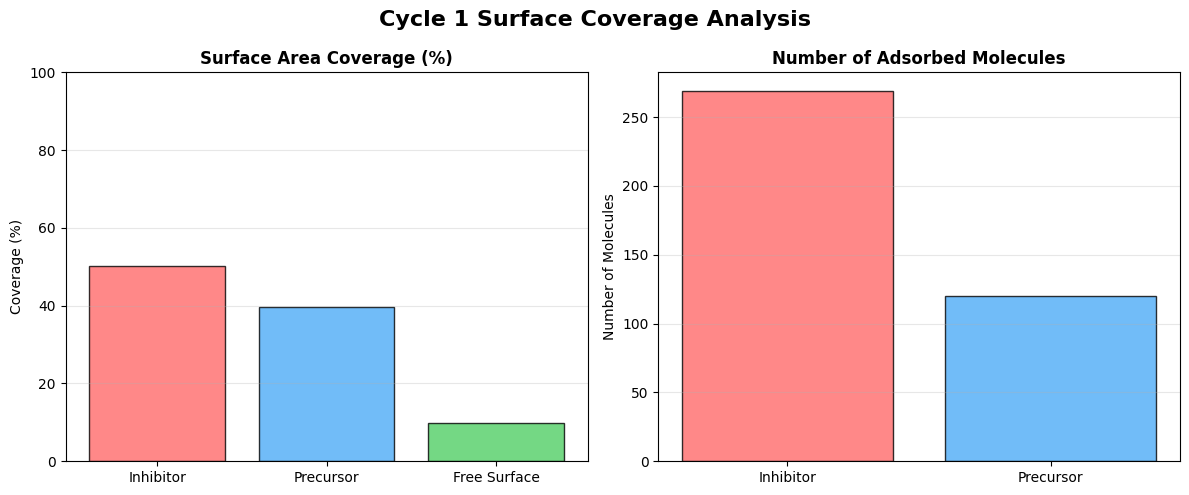

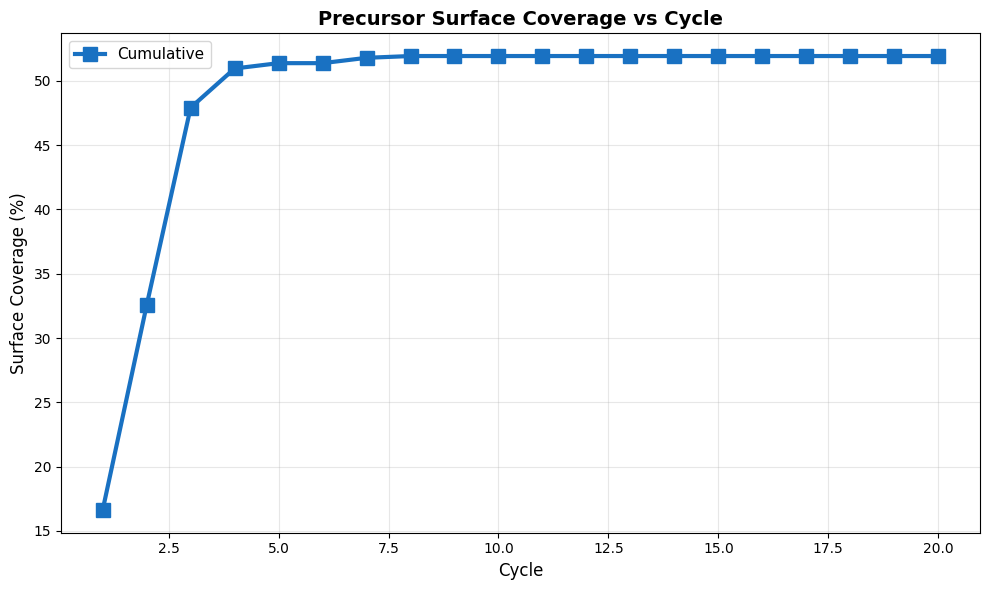

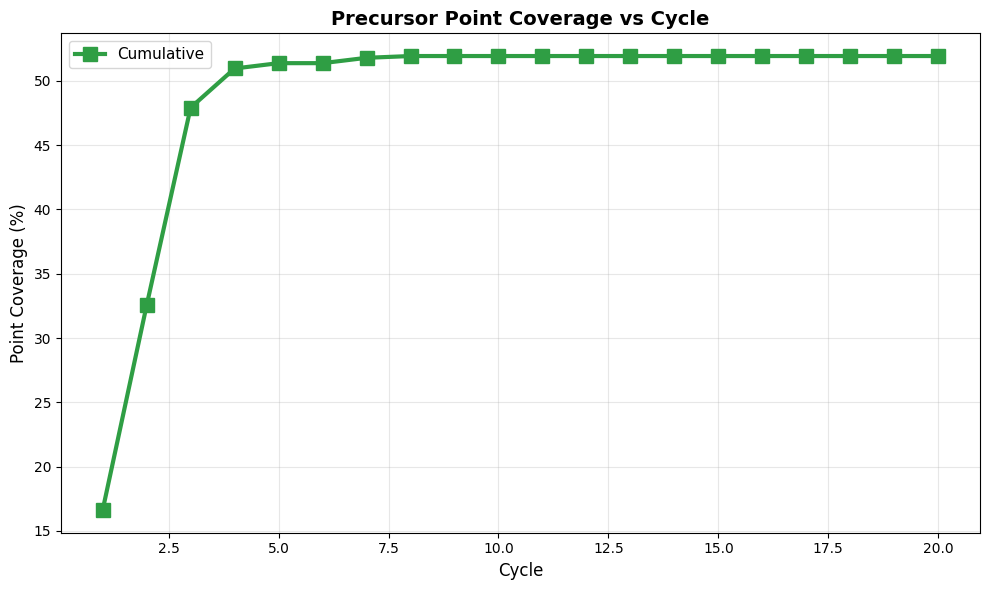

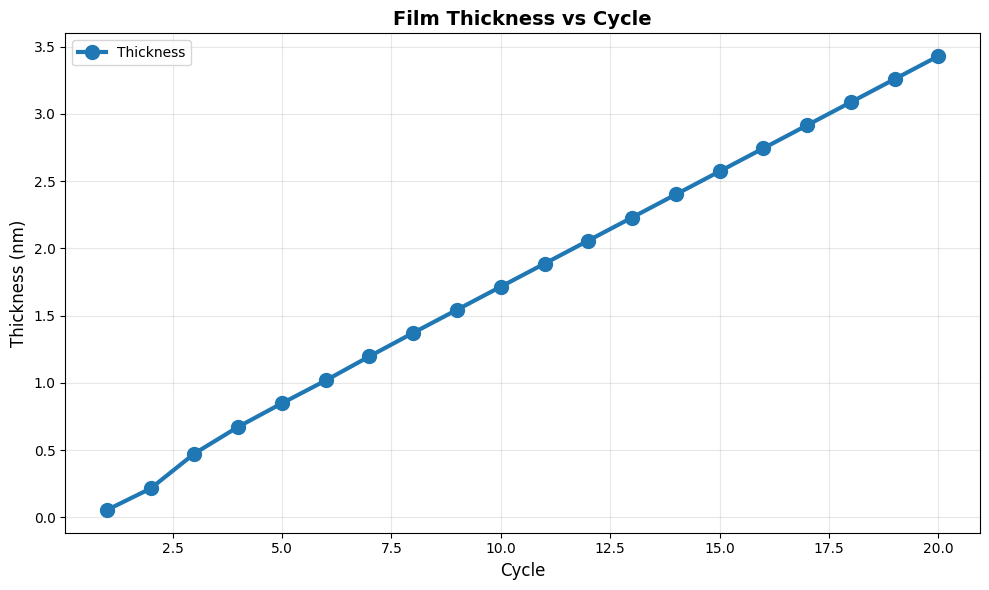

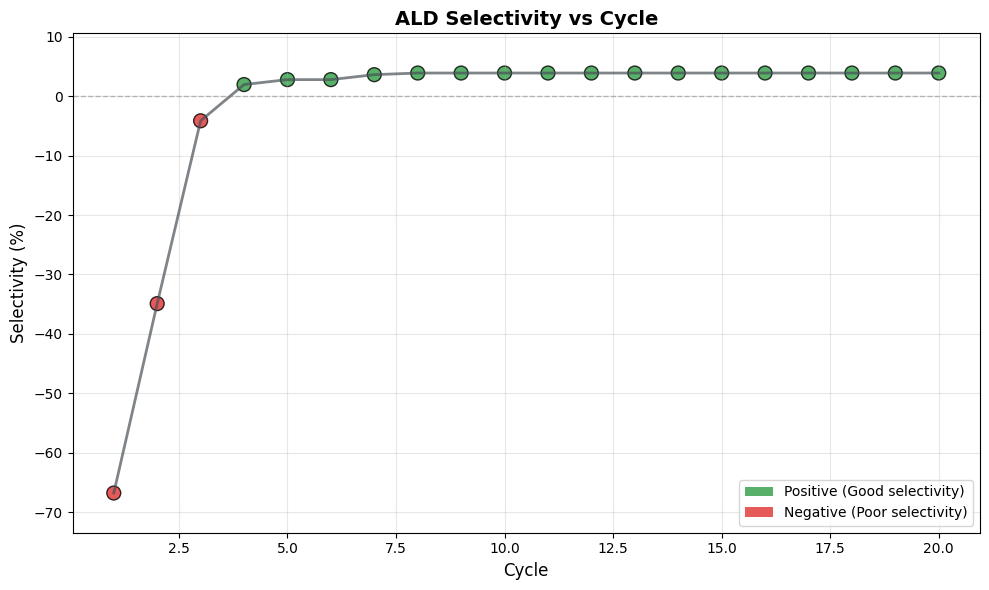

In [13]:
# T·∫°o analyzer t·ª´ d·ªØ li·ªáu m√¥ ph·ªèng
analyzer = create_analyzer_from_simulation_data(
    surface_area_nm2=surface_area_nm2,
    inhibitor_size_top_view_nm2=inhibitor_area_nm2,
    precursor_size_top_view_nm2=molecule_area_nm2,
    total_adsorption_sites=len(adsorption_sites),
    number_gas_inhibitors=number_gas_inhibitors,
    number_ads_inhibitors=number_ads_inhibitors,
    number_gas_precursor=number_gas_precursor,
    number_ads_precursor=number_ads_precursor,
    z_offset=2.0,
    density=6.95,  # SnO2 density
    molecular_mass=150.71  # SnO2 molecular mass
)

# V·∫Ω t·∫•t c·∫£ ƒë·ªì th·ªã
plots = plot_all_ald_analysis(analyzer)

# In b√°o c√°o chi ti·∫øt
report = analyzer.generate_comprehensive_report()
print(report)

# Hi·ªÉn th·ªã c√°c ƒë·ªì th·ªã
import matplotlib.pyplot as plt
plt.show()


# TEST 1

In [ ]:
'''
ƒêo·∫°n code n√†y m√¥ ph·ªèng qu√° tr√¨nh h·∫•p ph·ª• c·ªßa inhibitors v√† precursors tr√™n b·ªÅ m·∫∑t slab k√®m ch·∫•t ƒë·ªìng ph·∫£n ·ª©ng H2O 
theo quy tr√¨nh ALD v·ªõi c√°c chu k·ª≥ ƒë∆∞·ª£c x√°c ƒë·ªãnh r√µ r√†ng.
n = s·ªë l·∫ßn l·∫∑p qu√° tr√¨nh trong 1 chu k·ª≥
N_gas = s·ªë ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p
'''
from ase import Atoms
from ase.visualize import view
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree

# ƒê·∫£m b·∫£o c√≥ b√°n k√≠nh cho O (t·ª´ ph·∫£n ·ª©ng H2O)
if 'O' not in radius:
    radius['O'] = 1.52  # B√°n k√≠nh van der Waals c·ªßa O, ƒë∆°n v·ªã √Ö (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh)

# Th√™m c√°c tham s·ªë m√¥ ph·ªèng (n·∫øu ch∆∞a c√≥)
n = 3  # S·ªë l·∫ßn l·∫∑p qu√° tr√¨nh trong 1 chu k·ª≥
# N_gas = 5  # S·ªë ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p
# N = 2  # S·ªë chu k·ª≥ ALD
    
# Kh·ªüi t·∫°o danh s√°ch ƒë·ªÉ l∆∞u tr·ªØ c√°c ph√¢n t·ª≠
inhibitor_phase_molecules = []  # Ph√¢n t·ª≠ inhibitors trong giai ƒëo·∫°n kh√≠ (ch·ªâ chu k·ª≥ 1)
ads_inhibitor_molecules = []   # Ph√¢n t·ª≠ inhibitors ƒë√£ h·∫•p ph·ª• (ch·ªâ chu k·ª≥ 1)
ads_phase_molecules = []       # Ph√¢n t·ª≠ precursors ƒë√£ h·∫•p ph·ª• (t·∫•t c·∫£ chu k·ª≥)

# M·∫£ng theo d√µi s·ªë l∆∞·ª£ng ph√¢n t·ª≠
number_gas_inhibitors = np.array([])
number_ads_inhibitors = np.array([])
number_gas_precursor = np.array([])
number_ads_precursor = np.array([])

# ƒê·ªãnh nghƒ©a z-offset cho h·∫•p ph·ª• ontop (Sn tr√™n O)
z_offset = 2.0  # Kho·∫£ng c√°ch Sn-O, ƒë∆°n v·ªã √Ö (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh)

# Dictionary ƒë·ªÉ l∆∞u th√¥ng tin v·ªÅ chu k·ª≥ c·ªßa m·ªói v·ªã tr√≠ h·∫•p ph·ª• v√† ph√¢n t·ª≠
adsorption_cycle_info = {}  # key: (x, y, z) tuple c·ªßa v·ªã tr√≠ O, value: chu k·ª≥
molecules_by_cycle = {}     # key: chu k·ª≥, value: list c√°c ph√¢n t·ª≠

# Kh·ªüi t·∫°o cu_tree ban ƒë·∫ßu v·ªõi adsorption_sites
cu_tree = cKDTree(adsorption_sites)

# Kh·ªüi t·∫°o th√¥ng tin chu k·ª≥ cho c√°c v·ªã tr√≠ ban ƒë·∫ßu (chu k·ª≥ 0 - substrate)
for site in adsorption_sites:
    adsorption_cycle_info[tuple(site)] = 0

for cycle in range(1, N+1):
    print(f'\n{"="*50}')
    print(f'CYCLE {cycle}')
    print(f'{"="*50}')
    
    # Kh·ªüi t·∫°o molecules_by_cycle cho chu k·ª≥ hi·ªán t·∫°i
    molecules_by_cycle[cycle] = []
    
    if cycle == 1:
        print('--- CHU K·ª≤ 1: INHIBITORS + PRECURSORS + H2O ---')
        
        # ========== 1. GIAI ƒêO·∫†N INHIBITORS (CH·ªà CHU K·ª≤ 1) ==========
        print(f'\n1. INHIBITORS PHASE - {n} l·∫ßn l·∫∑p')
        inhibitor_phase_molecules = []  # Reset danh s√°ch
        ads_inhibitor_molecules = []    # Reset danh s√°ch
        
        # Th·ª±c hi·ªán n l·∫ßn l·∫∑p inhibitors
        for iteration in range(1, n+1):
            print(f'\n--- Inhibitor Iteration {iteration}/{n} ---')
            
            # 1a. Giai ƒëo·∫°n kh√≠ c·ªßa inhibitors (N_gas ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p)
            print(f'1a. Inhibitors Gas Phase - {N_gas} molecules')
            iteration_gas_molecules = []  # Ph√¢n t·ª≠ kh√≠ trong l·∫ßn l·∫∑p n√†y
            
            for i in range(1, N_gas+1):
                print(f'  Gas molecule {i}/{N_gas}')
                
                # Sao ch√©p ph√¢n t·ª≠ t·ª´ inhibitor_atoms
                molecule = inhibitor_atoms.copy()
                
                # T·∫°o v·ªã tr√≠ ng·∫´u nhi√™n v√† ma tr·∫≠n xoay
                pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
                
                # √Åp d·ª•ng xoay cho ph√¢n t·ª≠
                molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
                molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
                molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
                
                # D·ªãch ph√¢n t·ª≠ ƒë·∫øn v·ªã tr√≠ ng·∫´u nhi√™n
                offset = pos[0] - molecule[0].position
                molecule.translate(offset)
                
                # Ki·ªÉm tra steric hindrance CH·ªà v·ªõi molecules trong l·∫ßn l·∫∑p hi·ªán t·∫°i
                no_overlap = True
                if len(iteration_gas_molecules) > 0:
                    symbols = []
                    positions = []
                    
                    # Ch·ªâ th√™m t·ª´ l·∫ßn l·∫∑p hi·ªán t·∫°i
                    for prev_molecule in iteration_gas_molecules:
                        symbols.extend(prev_molecule.get_chemical_symbols())
                        positions.extend(prev_molecule.get_positions())
                    
                    all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                    
                    distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                    symbols1 = molecule.get_chemical_symbols()
                    symbols2 = all_gas_atoms.get_chemical_symbols()
                    radii1 = np.array([radius[s] for s in symbols1])
                    radii2 = np.array([radius[s] for s in symbols2])
                    radii_sums = radii1[:, None] + radii2[None, :]
                    
                    if not np.all(distances > radii_sums):
                        no_overlap = False
                
                if no_overlap:
                    print('    ‚úì Gas molecule accepted')
                    iteration_gas_molecules.append(molecule.copy())
                else:
                    print('    ‚úó Gas molecule rejected (steric hindrance)')
            
            # Th√™m c√°c ph√¢n t·ª≠ kh√≠ c·ªßa l·∫ßn l·∫∑p n√†y v√†o t·ªïng
            inhibitor_phase_molecules.extend(iteration_gas_molecules)
            print(f'  Iteration {iteration} gas phase: {len(iteration_gas_molecules)} molecules accepted')
            
            # 1b. Giai ƒëo·∫°n h·∫•p ph·ª• c·ªßa inhibitors trong l·∫ßn l·∫∑p n√†y
            print(f'1b. Inhibitors Adsorption Phase - Iteration {iteration}')
            
            for i, molecule in enumerate(tqdm(iteration_gas_molecules, desc=f"Adsorbing Inhibitors Iter {iteration}")):
                molecule_copy = molecule.copy()
                
                # T√¨m v·ªã tr√≠ h·∫•p ph·ª• g·∫ßn nh·∫•t
                distances, indices = cu_tree.query(molecule_copy[0].position, k=min(MAX_SITES, len(adsorption_sites)))
                
                # ƒê·∫£m b·∫£o indices l√† m·∫£ng 1D
                if isinstance(indices, (int, np.integer)):
                    indices = [indices]
                
                adsorbed = False
                for k in indices:
                    if k >= len(adsorption_sites):
                        continue
                        
                    O_site = adsorption_sites[k]
                    ads_molecule = rotated_inhibitor.copy()
                    offset = O_site - ads_molecule[0].position
                    ads_molecule.translate(offset)
                    ads_molecule = rotate_molecule_z_axis(ads_molecule)
                    
                    # Ki·ªÉm tra steric hindrance v·ªõi T·∫§T C·∫¢ ads_inhibitor_molecules
                    no_overlap = True
                    if len(ads_inhibitor_molecules) > 0:
                        symbols = []
                        positions = []
                        for prev_ads_molecule in ads_inhibitor_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                        symbols1 = ads_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                    
                    if no_overlap:
                        ads_inhibitor_molecules.append(ads_molecule.copy())
                        adsorbed = True
                        break
                
                if not adsorbed:
                    print(f'    Molecule {i+1} could not be adsorbed')
            
            print(f'  Iteration {iteration} adsorption: {len(ads_inhibitor_molecules)} total inhibitors adsorbed')
        
        print(f'\nInhibitors Phase Completed:')
        print(f'  Total gas molecules: {len(inhibitor_phase_molecules)}')
        print(f'  Total adsorbed molecules: {len(ads_inhibitor_molecules)}')
    
    # ========== 2. GIAI ƒêO·∫†N PRECURSORS (T·∫§T C·∫¢ CHU K·ª≤) ==========
    print(f'\n2. PRECURSORS PHASE - {n} l·∫ßn l·∫∑p (Cycle {cycle})')
    cycle_gas_molecules = []      # T·∫•t c·∫£ gas molecules trong chu k·ª≥ n√†y
    cycle_ads_molecules = []      # T·∫•t c·∫£ adsorbed molecules trong chu k·ª≥ n√†y
    
    # X√°c ƒë·ªãnh v·ªã tr√≠ h·∫•p ph·ª• cho chu k·ª≥ hi·ªán t·∫°i
    if cycle == 1:
        adsorption_positions = adsorption_sites
        print(f'  Using original adsorption sites: {len(adsorption_positions)} sites')
    else:
        # Chu k·ª≥ 2+: S·ª≠ d·ª•ng v·ªã tr√≠ O t·ª´ ads_phase_molecules
        adsorption_positions = []
        adsorption_positions_cycle_map = {}  # Map t·ª´ v·ªã tr√≠ ƒë·∫øn chu k·ª≥ g·ªëc
        
        for molecule in ads_phase_molecules:
            symbols = molecule.get_chemical_symbols()
            positions = molecule.get_positions()
            
            # T√¨m chu k·ª≥ c·ªßa ph√¢n t·ª≠ n√†y
            molecule_cycle = None
            for cycle_key, cycle_molecules in molecules_by_cycle.items():
                if molecule in cycle_molecules:
                    molecule_cycle = cycle_key
                    break
            
            if molecule_cycle is None:
                molecule_cycle = 1  # Default cho c√°c ph√¢n t·ª≠ t·ª´ chu k·ª≥ 1
            
            for idx, symbol in enumerate(symbols):
                if symbol == 'O':
                    pos_tuple = tuple(positions[idx])
                    adsorption_positions.append(positions[idx])
                    adsorption_positions_cycle_map[len(adsorption_positions)-1] = molecule_cycle
        
        adsorption_positions = np.array(adsorption_positions)
        
        if len(adsorption_positions) == 0:
            print(f"  Warning: No O atoms found for adsorption in cycle {cycle}. Skipping precursor phase.")
            number_gas_inhibitors = np.append(number_gas_inhibitors, 0)
            number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
            number_gas_precursor = np.append(number_gas_precursor, 0)
            number_ads_precursor = np.append(number_ads_precursor, 0)
            continue
        
        print(f'  Using O atom positions from previous cycles: {len(adsorption_positions)} sites')
    
    # T·∫°o l·∫°i cu_tree v·ªõi adsorption_positions
    cu_tree = cKDTree(adsorption_positions)
    
    # Th·ª±c hi·ªán n l·∫ßn l·∫∑p precursors
    for iteration in range(1, n+1):
        print(f'\n--- Precursor Iteration {iteration}/{n} ---')
        
        # 2a. Giai ƒëo·∫°n kh√≠ c·ªßa precursors (N_gas ph√¢n t·ª≠ trong 1 l·∫ßn l·∫∑p)
        print(f'2a. Precursors Gas Phase - {N_gas} molecules')
        iteration_gas_molecules = []  # Ph√¢n t·ª≠ kh√≠ trong l·∫ßn l·∫∑p n√†y
        
        for i in range(1, N_gas+1):
            print(f'  Gas molecule {i}/{N_gas}')
            
            # Sao ch√©p ph√¢n t·ª≠ t·ª´ atoms
            molecule = atoms.copy()
            
            # T·∫°o v·ªã tr√≠ ng·∫´u nhi√™n v√† ma tr·∫≠n xoay
            pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
            
            # √Åp d·ª•ng xoay cho ph√¢n t·ª≠
            molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
            molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
            molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
            
            # D·ªãch ph√¢n t·ª≠ ƒë·∫øn v·ªã tr√≠ ng·∫´u nhi√™n
            offset = pos[0] - molecule[0].position
            molecule.translate(offset)
            
            # Ki·ªÉm tra steric hindrance CH·ªà v·ªõi molecules trong l·∫ßn l·∫∑p hi·ªán t·∫°i
            no_overlap = True
            if len(iteration_gas_molecules) > 0:
                symbols = []
                positions = []
                
                # Ch·ªâ th√™m t·ª´ l·∫ßn l·∫∑p hi·ªán t·∫°i
                for prev_molecule in iteration_gas_molecules:
                    symbols.extend(prev_molecule.get_chemical_symbols())
                    positions.extend(prev_molecule.get_positions())
                
                all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                symbols1 = molecule.get_chemical_symbols()
                symbols2 = all_gas_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if not np.all(distances > radii_sums):
                    no_overlap = False
            
            if no_overlap:
                print('    ‚úì Gas molecule accepted')
                iteration_gas_molecules.append(molecule.copy())
            else:
                print('    ‚úó Gas molecule rejected (steric hindrance)')
        
        # Th√™m c√°c ph√¢n t·ª≠ kh√≠ c·ªßa l·∫ßn l·∫∑p n√†y v√†o chu k·ª≥
        cycle_gas_molecules.extend(iteration_gas_molecules)
        print(f'  Iteration {iteration} gas phase: {len(iteration_gas_molecules)} molecules accepted')
        
        # 2b. Giai ƒëo·∫°n h·∫•p ph·ª• c·ªßa precursors trong l·∫ßn l·∫∑p n√†y
        print(f'2b. Precursors Adsorption Phase - Iteration {iteration}')
        
        for i, molecule in enumerate(tqdm(iteration_gas_molecules, desc=f"Adsorbing Precursors Iter {iteration}")):
            molecule_copy = molecule.copy()
            
            # T√¨m v·ªã tr√≠ h·∫•p ph·ª• g·∫ßn nh·∫•t
            k = min(MAX_SITES, len(adsorption_positions))
            distances, indices = cu_tree.query(molecule_copy[0].position, k=k)
            
            # ƒê·∫£m b·∫£o indices l√† m·∫£ng 1D
            if isinstance(indices, (int, np.integer)):
                indices = [indices]
            
            adsorbed = False
            for k_idx in indices:
                if k_idx >= len(adsorption_positions):
                    continue
                    
                O_site = adsorption_positions[k_idx]
                ads_molecule = rotated_adsorbate.copy()
                offset = O_site - ads_molecule[0].position
                
                # X√°c ƒë·ªãnh chu k·ª≥ g·ªëc c·ªßa v·ªã tr√≠ h·∫•p ph·ª• v√† target_layer
                if cycle == 1:
                    original_cycle = 0  # Substrate
                    target_layer = 1   # Layer 1 (tr√™n substrate)
                    layer_z_offset = z_offset  # Layer 1 lu√¥n c√≥ z_offset c·ªë ƒë·ªãnh t·ª´ substrate
                else:
                    original_cycle = adsorption_positions_cycle_map[k_idx]
                    target_layer = original_cycle + 1  # Layer ti·∫øp theo
                    # Layer_z_offset ƒë∆∞·ª£c t√≠nh t·ª´ substrate (layer 0)
                    layer_z_offset = target_layer * z_offset
                
                # Th√™m z-offset d·ª±a tr√™n target_layer
                offset += np.array([0, 0, layer_z_offset])
                    
                ads_molecule.translate(offset)
                ads_molecule = rotate_molecule_z_axis(ads_molecule)
                
                # LOGIC CH√çNH X√ÅC: Ki·ªÉm tra steric hindrance v·ªõi c√°c ph√¢n t·ª≠ t·ª´ target_layer ƒë·∫øn cycle hi·ªán t·∫°i
                no_overlap = True
                blocking_layer = None
                
                # Ki·ªÉm tra steric hindrance v·ªõi t·∫•t c·∫£ c√°c layer t·ª´ target_layer ƒë·∫øn cycle hi·ªán t·∫°i
                for check_layer in range(target_layer, cycle + 1):
                    check_molecules = []
                    
                    if check_layer == cycle:
                        # Layer hi·ªán t·∫°i: ki·ªÉm tra v·ªõi c√°c ph√¢n t·ª≠ ƒë√£ h·∫•p ph·ª• trong chu k·ª≥ hi·ªán t·∫°i
                        check_molecules = cycle_ads_molecules.copy()
                    else:
                        # Layer c≈© h∆°n: ki·ªÉm tra v·ªõi c√°c ph√¢n t·ª≠ ·ªü layer ƒë√≥
                        if check_layer in molecules_by_cycle:
                            check_molecules = molecules_by_cycle[check_layer].copy()
                    
                    if len(check_molecules) > 0:
                        # T·∫°o ph√¢n t·ª≠ test v·ªõi z_offset c·ªßa layer ƒëang ki·ªÉm tra
                        test_molecule = rotated_adsorbate.copy()
                        test_offset = O_site - test_molecule[0].position
                        # Z-offset ƒë∆∞·ª£c t√≠nh t·ª´ substrate (layer 0)
                        check_layer_z_offset = check_layer * z_offset
                        test_offset += np.array([0, 0, check_layer_z_offset])
                        test_molecule.translate(test_offset)
                        test_molecule = rotate_molecule_z_axis(test_molecule)
                        
                        symbols = []
                        positions = []
                        for prev_ads_molecule in check_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(test_molecule.positions, all_ads_atoms.positions)
                        symbols1 = test_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                            blocking_layer = check_layer
                            break  # D·ª´ng ngay khi g·∫∑p steric hindrance
                
                # S·ª≠ d·ª•ng ads_molecule ƒë√£ t√≠nh to√°n v·ªõi z_offset ch√≠nh x√°c c·ªßa target_layer
                # (ads_molecule ƒë√£ ƒë∆∞·ª£c t√≠nh to√°n v·ªõi layer_z_offset ·ªü tr√™n)
                
                if no_overlap:
                    cycle_ads_molecules.append(ads_molecule.copy())
                    print(f'    ‚úì Molecule {i+1} adsorbed at layer {target_layer} (from cycle {original_cycle} site, z_offset={layer_z_offset:.1f})')
                    adsorbed = True
                    break
                else:
                    print(f'    ‚úó Molecule {i+1} rejected at layer {target_layer} (blocked by layer {blocking_layer})')
            
            if not adsorbed:
                print(f'    Molecule {i+1} could not be adsorbed at any site')
        
        print(f'  Iteration {iteration} adsorption: {len(cycle_ads_molecules)} total precursors adsorbed in cycle')
    
    print(f'\nPrecursors Phase Completed (Cycle {cycle}):')
    print(f'  Total gas molecules: {len(cycle_gas_molecules)}')
    print(f'  Total adsorbed molecules: {len(cycle_ads_molecules)}')
    
    # ========== 3. GIAI ƒêO·∫†N PH·∫¢N ·ª®NG H2O (1 L·∫¶N/CHU K·ª≤) ==========
    print(f'\n3. H2O REACTION PHASE (Cycle {cycle}) - 1 l·∫ßn')
    print('  Starting H2O Reaction: Replacing all Cl with O')
    
    cl_replaced_total = 0
    for i, molecule in enumerate(tqdm(cycle_ads_molecules, desc="Processing H2O Reaction")):
        # Thay to√†n b·ªô Cl b·∫±ng O
        symbols = molecule.get_chemical_symbols()
        positions = molecule.get_positions()
        cl_count = 0
        
        for idx, symbol in enumerate(symbols):
            if symbol == 'Cl':
                symbols[idx] = 'O'
                cl_count += 1
                # C·∫≠p nh·∫≠t th√¥ng tin chu k·ª≥ cho v·ªã tr√≠ O m·ªõi
                adsorption_cycle_info[tuple(positions[idx])] = cycle
        
        molecule.set_chemical_symbols(symbols)
        cl_replaced_total += cl_count
        
        if cl_count > 0:
            print(f'  Molecule {i+1}: Replaced {cl_count} Cl atoms with O')
    
    # L∆∞u c√°c ph√¢n t·ª≠ c·ªßa chu k·ª≥ hi·ªán t·∫°i v√†o molecules_by_cycle
    molecules_by_cycle[cycle] = cycle_ads_molecules.copy()
    
    # Th√™m c√°c ph√¢n t·ª≠ ƒë√£ ph·∫£n ·ª©ng v√†o ads_phase_molecules
    ads_phase_molecules.extend(cycle_ads_molecules)
    print(f'  H2O Reaction Completed: {len(cycle_ads_molecules)} molecules, {cl_replaced_total} Cl‚ÜíO replacements')
    
    # ========== 4. C·∫¨P NH·∫¨T S·ªê LI·ªÜU TH·ªêNG K√ä ==========
    number_gas_inhibitors = np.append(number_gas_inhibitors, len(inhibitor_phase_molecules) if cycle == 1 else 0)
    number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
    number_gas_precursor = np.append(number_gas_precursor, len(cycle_gas_molecules))
    number_ads_precursor = np.append(number_ads_precursor, len(cycle_ads_molecules))
    
    print(f'\n{"="*20} END CYCLE {cycle} SUMMARY {"="*20}')
    print(f'Gas inhibitors: {len(inhibitor_phase_molecules) if cycle == 1 else 0}')
    print(f'Adsorbed inhibitors: {len(ads_inhibitor_molecules) if cycle == 1 else 0}')
    print(f'Gas precursors: {len(cycle_gas_molecules)}')
    print(f'Adsorbed precursors: {len(cycle_ads_molecules)}')
    print(f'Total molecules in system: {len(ads_inhibitor_molecules) + len(ads_phase_molecules)}')
    print(f'Molecules by layer: {[(k, len(v)) for k, v in molecules_by_cycle.items()]}')

In [ ]:
# ========== 5. HI·ªÇN TH·ªä K·∫æT QU·∫¢ CU·ªêI C√ôNG ==========
print(f'\n{"="*60}')
print('FINAL SIMULATION RESULTS')
print(f'{"="*60}')
print(f'Total cycles completed: {N}')
print(f'Iterations per cycle: {n}')
print(f'Molecules per iteration: {N_gas}')
print(f'Total inhibitors adsorbed: {len(ads_inhibitor_molecules)}')
print(f'Total precursors processed through all cycles: {len(ads_phase_molecules)}')

# G·ªôp t·∫•t c·∫£ ph√¢n t·ª≠ ƒë·ªÉ hi·ªÉn th·ªã b·∫±ng nglview
all_adsorbed_molecules = []
all_adsorbed_molecules.extend(ads_inhibitor_molecules)  # Inhibitors t·ª´ chu k·ª≥ 1
all_adsorbed_molecules.extend(ads_phase_molecules)      # Precursors t·ª´ t·∫•t c·∫£ chu k·ª≥

print(f'Total molecules for visualization: {len(all_adsorbed_molecules)}')

# T·∫°o structure t·ªïng h·ª£p ƒë·ªÉ hi·ªÉn th·ªã
if len(all_adsorbed_molecules) > 0:
    # G·ªôp t·∫•t c·∫£ symbols v√† positions
    all_symbols = []
    all_positions = []
    
    # Th√™m slab
    all_symbols.extend(slab.get_chemical_symbols())
    all_positions.extend(slab.get_positions())
    
    # Th√™m t·∫•t c·∫£ ph√¢n t·ª≠ ƒë√£ h·∫•p ph·ª•
    for molecule in all_adsorbed_molecules:
        all_symbols.extend(molecule.get_chemical_symbols())
        all_positions.extend(molecule.get_positions())
    
    # T·∫°o structure cu·ªëi c√πng
    final_structure = Atoms(symbols=all_symbols, positions=all_positions)
    print('‚úì Final structure created successfully for visualization')
    
    # HI·ªÇN TH·ªä K·∫æT QU·∫¢ B·∫∞NG NGLVIEW
    print('\nüìä VISUALIZATION')
    print('Displaying final structure with nglview...')
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('‚úì Structure displayed successfully')
    except Exception as e:
        print(f'‚úó Error displaying structure: {e}')
        print('You can manually visualize using: view(final_structure)')
    '''
        
else:
    print('‚ö†Ô∏è  No molecules were adsorbed. Only slab will be available for visualization.')
    final_structure = slab.copy()
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('‚úì Slab-only structure displayed')
    except Exception as e:
        print(f'‚úó Error displaying slab: {e}')
    '''

print('\nüéâ SIMULATION COMPLETED SUCCESSFULLY!')
print(f'Final structure variable: final_structure')
print(f'Total atoms in final structure: {len(final_structure)}')

# In th·ªëng k√™ chi ti·∫øt
print(f'\nüìà DETAILED STATISTICS:')
for i in range(len(number_gas_inhibitors)):
    cycle_num = i + 1
    print(f'Cycle {cycle_num}:')
    print(f'  - Gas inhibitors: {int(number_gas_inhibitors[i])}')
    print(f'  - Adsorbed inhibitors: {int(number_ads_inhibitors[i])}')
    print(f'  - Gas precursors: {int(number_gas_precursor[i])}')
    print(f'  - Adsorbed precursors: {int(number_ads_precursor[i])}')


view(final_structure, viewer='ngl')

# Run

In [ ]:
'''
ƒêo·∫°n code n√†y m√¥ ph·ªèng qu√° tr√¨nh h·∫•p ph·ª• c·ªßa inhibitors v√† precursors tr√™n b·ªÅ m·∫∑t slab k√®m ch·∫•t ƒë·ªìng ph·∫£n ·ª©ng H2O.
'''
from ase import Atoms
from ase.visualize import view
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree  # Gi·∫£ s·ª≠ cu_tree l√† cKDTree

# ƒê·∫£m b·∫£o c√≥ b√°n k√≠nh cho O (t·ª´ ph·∫£n ·ª©ng H2O)
if 'O' not in radius:
    radius['O'] = 1.52  # B√°n k√≠nh van der Waals c·ªßa O, ƒë∆°n v·ªã √Ö (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh)
    
# Kh·ªüi t·∫°o danh s√°ch ƒë·ªÉ l∆∞u tr·ªØ c√°c ph√¢n t·ª≠
inhibitor_phase_molecules = []  # Ph√¢n t·ª≠ inhibitors trong giai ƒëo·∫°n kh√≠
ads_inhibitor_molecules = []   # Ph√¢n t·ª≠ inhibitors ƒë√£ h·∫•p ph·ª•
gas_phase_molecules = []       # Ph√¢n t·ª≠ precursors trong giai ƒëo·∫°n kh√≠
ads_phase_molecules = []       # Ph√¢n t·ª≠ precursors ƒë√£ h·∫•p ph·ª•
number_gas_inhibitors = np.array([])  # S·ªë l∆∞·ª£ng inhibitors trong giai ƒëo·∫°n kh√≠
number_ads_inhibitors = np.array([])  # S·ªë l∆∞·ª£ng inhibitors ƒë√£ h·∫•p ph·ª•
number_gas_precursor = np.array([])   # S·ªë l∆∞·ª£ng precursors trong giai ƒëo·∫°n kh√≠
number_ads_precursor = np.array([])   # S·ªë l∆∞·ª£ng precursors ƒë√£ h·∫•p ph·ª•

# ƒê·ªãnh nghƒ©a z-offset cho h·∫•p ph·ª• ontop (Sn tr√™n O)
z_offset = 2.0  # Kho·∫£ng c√°ch Sn-O, ƒë∆°n v·ªã √Ö (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh)

for j in range(1, N+1):
    print(f'Cycle {j}')
    
    if j == 1:
        # 1. Giai ƒëo·∫°n kh√≠ c·ªßa inhibitors (ch·ªâ trong chu k·ª≥ 1)
        inhibitor_phase_molecules = []  # Reset danh s√°ch
        for i in range(1, N_gas+1):
            print(f'Inhibitor: {i}')
            
            # Sao ch√©p ph√¢n t·ª≠ t·ª´ inhibitor_atoms
            molecule = inhibitor_atoms.copy()
            
            # T·∫°o v·ªã tr√≠ ng·∫´u nhi√™n v√† ma tr·∫≠n xoay
            pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
            
            # √Åp d·ª•ng xoay cho ph√¢n t·ª≠
            molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
            molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
            molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
            
            # D·ªãch ph√¢n t·ª≠ ƒë·∫øn v·ªã tr√≠ ng·∫´u nhi√™n
            offset = pos[0] - molecule[0].position
            molecule.translate(offset)
            
            # Ki·ªÉm tra steric hindrance trong giai ƒëo·∫°n kh√≠ c·ªßa inhibitors
            no_overlap = False
            if len(inhibitor_phase_molecules) > 0:
                symbols = []
                positions = []
                for prev_molecule in inhibitor_phase_molecules:
                    symbols.extend(prev_molecule.get_chemical_symbols())
                    positions.extend(prev_molecule.get_positions())
                all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                symbols1 = molecule.get_chemical_symbols()
                symbols2 = all_gas_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if np.all(distances > radii_sums):
                    no_overlap = True
            else:
                no_overlap = True
            
            if no_overlap:
                print('Inhibitors Conditions Verified')
                inhibitor_phase_molecules.append(molecule.copy())
        
        print('Inhibitors Gas Layer Completed')
        
        # 2. Giai ƒëo·∫°n h·∫•p ph·ª• c·ªßa inhibitors (ch·ªâ trong chu k·ª≥ 1)
        for i in tqdm(range(len(inhibitor_phase_molecules)), desc="Calculating Inhibitor Adsorption"):
            molecule = inhibitor_phase_molecules[i].copy()
            
            # T√¨m v·ªã tr√≠ h·∫•p ph·ª• g·∫ßn nh·∫•t
            distances, indices = cu_tree.query(molecule[0].position, k=min(MAX_SITES, len(adsorption_sites)))
            
            # ƒê·∫£m b·∫£o indices l√† m·∫£ng 1D
            if isinstance(indices, (int, np.integer)):
                indices = [indices]
            
            for k in indices:
                if k >= len(adsorption_sites):  # Ki·ªÉm tra ch·ªâ s·ªë h·ª£p l·ªá
                    continue
                O_site = adsorption_sites[k]
                ads_molecule = rotated_inhibitor.copy()
                offset = O_site - ads_molecule[0].position
                ads_molecule.translate(offset)
                ads_molecule = rotate_molecule_z_axis(ads_molecule)
                
                # Ki·ªÉm tra steric hindrance v·ªõi c√°c inhibitors ƒë√£ h·∫•p ph·ª•
                no_overlap = False
                if len(ads_inhibitor_molecules) > 0:
                    symbols = []
                    positions = []
                    for prev_ads_molecule in ads_inhibitor_molecules:
                        symbols.extend(prev_ads_molecule.get_chemical_symbols())
                        positions.extend(prev_ads_molecule.get_positions())
                    all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                    
                    distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                    symbols1 = ads_molecule.get_chemical_symbols()
                    symbols2 = all_ads_atoms.get_chemical_symbols()
                    radii1 = np.array([radius[s] for s in symbols1])
                    radii2 = np.array([radius[s] for s in symbols2])
                    radii_sums = radii1[:, None] + radii2[None, :]
                    
                    if np.all(distances > radii_sums):
                        no_overlap = True
                else:
                    no_overlap = True
                
                if no_overlap:
                    print('Inhibitor Adsorption On Substrate Successfully')
                    ads_inhibitor_molecules.append(ads_molecule.copy())
                    break
        
        print('Inhibitors Adsorption On Substrate Completed')
    
    # 3. Giai ƒëo·∫°n kh√≠ c·ªßa precursors
    gas_phase_molecules = []  # Reset danh s√°ch cho m·ªói chu k·ª≥
    for i in range(1, N_gas+1):
        print(f'Precursor: {i}')
        
        # Sao ch√©p ph√¢n t·ª≠ t·ª´ atoms
        molecule = atoms.copy()
        
        # T·∫°o v·ªã tr√≠ ng·∫´u nhi√™n v√† ma tr·∫≠n xoay
        pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
        
        # √Åp d·ª•ng xoay cho ph√¢n t·ª≠
        molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
        molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
        molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
        
        # D·ªãch ph√¢n t·ª≠ ƒë·∫øn v·ªã tr√≠ ng·∫´u nhi√™n
        offset = pos[0] - molecule[0].position
        molecule.translate(offset)
        
        # Ki·ªÉm tra steric hindrance trong giai ƒëo·∫°n kh√≠ c·ªßa precursors
        no_overlap = False
        if len(gas_phase_molecules) > 0:
            symbols = []
            positions = []
            for prev_molecule in gas_phase_molecules:
                symbols.extend(prev_molecule.get_chemical_symbols())
                positions.extend(prev_molecule.get_positions())
            all_gas_atoms = Atoms(symbols=symbols, positions=positions)
            
            distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
            symbols1 = molecule.get_chemical_symbols()
            symbols2 = all_gas_atoms.get_chemical_symbols()
            radii1 = np.array([radius[s] for s in symbols1])
            radii2 = np.array([radius[s] for s in symbols2])
            radii_sums = radii1[:, None] + radii2[None, :]
            
            if np.all(distances > radii_sums):
                no_overlap = True
        else:
            no_overlap = True
        
        if no_overlap:
            print('Precursors Conditions Verified')
            gas_phase_molecules.append(molecule.copy())
    
    print('Precursors Gas Layer Completed')
    
    # 4. Giai ƒëo·∫°n h·∫•p ph·ª• c·ªßa precursors
    if j == 1:
        # Chu k·ª≥ 1: S·ª≠ d·ª•ng adsorption_sites
        adsorption_positions = adsorption_sites
        cu_tree = cKDTree(adsorption_positions)  # Kh·ªüi t·∫°o l·∫°i cu_tree
    else:
        # Chu k·ª≥ 2 tr·ªü ƒëi: S·ª≠ d·ª•ng v·ªã tr√≠ c·ªßa nguy√™n t·ª≠ O t·ª´ ads_phase_molecules
        adsorption_positions = []
        for molecule in ads_phase_molecules:
            symbols = molecule.get_chemical_symbols()
            positions = molecule.get_positions()
            for idx, symbol in enumerate(symbols):
                if symbol == 'O':
                    adsorption_positions.append(positions[idx])
        adsorption_positions = np.array(adsorption_positions)
        if len(adsorption_positions) == 0:
            print(f"Warning: No O atoms found for adsorption in cycle {j}. Skipping precursor adsorption.")
            number_gas_precursor = np.append(number_gas_precursor, len(gas_phase_molecules))
            number_ads_precursor = np.append(number_ads_precursor, 0)
            continue
        cu_tree = cKDTree(adsorption_positions)  # Kh·ªüi t·∫°o l·∫°i cu_tree v·ªõi adsorption_positions m·ªõi
    
    new_ads_molecules = []  # Danh s√°ch t·∫°m ƒë·ªÉ l∆∞u tr·ªØ precursors h·∫•p ph·ª• trong chu k·ª≥ n√†y
    for i in tqdm(range(len(gas_phase_molecules)), desc="Calculating Precursor Adsorption"):
        molecule = gas_phase_molecules[i].copy()
        
        # T√¨m v·ªã tr√≠ h·∫•p ph·ª• g·∫ßn nh·∫•t
        k = min(MAX_SITES, len(adsorption_positions))  # Gi·ªõi h·∫°n k
        distances, indices = cu_tree.query(molecule[0].position, k=k)
        
        # ƒê·∫£m b·∫£o indices l√† m·∫£ng 1D
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
        
        for k_idx in indices:
            if k_idx >= len(adsorption_positions):  # Ki·ªÉm tra ch·ªâ s·ªë h·ª£p l·ªá
                continue
            O_site = adsorption_positions[k_idx]
            ads_molecule = rotated_adsorbate.copy()
            offset = O_site - ads_molecule[0].position
            if j > 1:
                offset += np.array([0, 0, z_offset])  # Th√™m z-offset cho chu k·ª≥ 2+
            ads_molecule.translate(offset)
            ads_molecule = rotate_molecule_z_axis(ads_molecule)
            
            # Ki·ªÉm tra steric hindrance ch·ªâ v·ªõi c√°c precursors ƒë√£ h·∫•p ph·ª• trong chu k·ª≥ n√†y
            no_overlap = False
            if len(new_ads_molecules) > 0:
                symbols = []
                positions = []
                for prev_ads_molecule in new_ads_molecules:
                    symbols.extend(prev_ads_molecule.get_chemical_symbols())
                    positions.extend(prev_ads_molecule.get_positions())
                all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                symbols1 = ads_molecule.get_chemical_symbols()
                symbols2 = all_ads_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if np.all(distances > radii_sums):
                    no_overlap = True
            else:
                no_overlap = True
            
            if no_overlap:
                print('Precursor Adsorption On Substrate Successfully')
                new_ads_molecules.append(ads_molecule.copy())
                break
    
    print('Precursors Adsorption On Substrate Completed')
    
    # 5. Giai ƒëo·∫°n ph·∫£n ·ª©ng v·ªõi H2O: Thay to√†n b·ªô Cl b·∫±ng O
    print('Starting H2O Reaction Phase')
    for i in tqdm(range(len(new_ads_molecules)), desc="Processing H2O Reaction"):
        molecule = new_ads_molecules[i]
        
        # Thay to√†n b·ªô Cl b·∫±ng O
        symbols = molecule.get_chemical_symbols()
        for idx, symbol in enumerate(symbols):
            if symbol == 'Cl':
                symbols[idx] = 'O'
        molecule.set_chemical_symbols(symbols)
        print(f'Replaced all Cl with O in molecule {i+1}')
    
    ads_phase_molecules.extend(new_ads_molecules)
    print('H2O Reaction Phase Completed')
    
    # C·∫≠p nh·∫≠t s·ªë l∆∞·ª£ng ph√¢n t·ª≠
    number_gas_inhibitors = np.append(number_gas_inhibitors, len(inhibitor_phase_molecules) if j == 1 else 0)
    number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules))
    number_gas_precursor = np.append(number_gas_precursor, len(gas_phase_molecules))
    number_ads_precursor = np.append(number_ads_precursor, len(new_ads_molecules))


In [ ]:
# Hi·ªÉn th·ªã c·∫•u tr√∫c
if len(ads_phase_molecules) == 0 and len(ads_inhibitor_molecules) == 0:
    print("Warning: No adsorbed molecules (inhibitors or precursors) found. Visualization will only show the slab.")
    combined = slab.copy()
else:
    # G·ªôp t·∫•t c·∫£ c√°c ph√¢n t·ª≠ h·∫•p ph·ª• (inhibitors v√† precursors) th√†nh m·ªôt ƒë·ªëi t∆∞·ª£ng Atoms
    adsorbates = Atoms()
    for molecule in ads_inhibitor_molecules + ads_phase_molecules:
        adsorbates += molecule
    
    # Thi·∫øt l·∫≠p √¥ ƒë∆°n v·ªã v√† ƒëi·ªÅu ki·ªán bi√™n cho adsorbates
    adsorbates.cell = slab.cell
    adsorbates.pbc = slab.pbc

    # K·∫øt h·ª£p slab v√† adsorbates
    combined = slab + adsorbates

# Hi·ªÉn th·ªã c·∫•u tr√∫c b·∫±ng ASE view v·ªõi nglview
view(combined, viewer='ngl')